In [1]:
using Distributions
using Random
using LinearAlgebra
using ProgressMeter
E = LinearAlgebra.I
eye(n) = Matrix(1.0E,n,n) #identity matrix

#
#import Fontconfig, Cairo
using Gadfly

┌ Info: Precompiling Distributions [31c24e10-a181-5473-b8eb-7969acd0382f]
└ @ Base loading.jl:1273
┌ Info: Precompiling ProgressMeter [92933f4c-e287-5a05-a399-4b506db050ca]
└ @ Base loading.jl:1273
┌ Info: Precompiling Gadfly [c91e804a-d5a3-530f-b6f0-dfbca275c004]
└ @ Base loading.jl:1273


# Numerical Calculation of Real Log Canonical Threshold in LDA using Gibbs Sampler

## True, Learner, and Prior

Let $x \in \mathrm{Onehot}(M)$, $y\in \mathrm{Onehot}(H)$ and $z\in \mathrm{Onehot}(N)$ be the word, the topic, and the document, respectively. The true or optimal topic is $y^0 \in \mathrm{Onehot}(H_0)$.

The true (data generating) distribution is
$$q(x,y^0|z) = \prod_{j=1}^N \left[\prod_{k=1}^{H_0} \left(b^0_{kj} \prod_{i=1}^M (a^0_{ik})^{x_{i}}\right)^{y^0_k}\right]^{z_j}.$$

The learning machine (statistical or likelihood model) is
$$p(x,y|z,A,B) = \prod_{j=1}^N \left[\prod_{k=1}^{H} \left(b_{kj} \prod_{i=1}^M (a_{ik})^{x_{i}}\right)^{y_k}\right]^{z_j}.$$

The parameters $A=(a_{ik})$ and $B=(b_{kj})$ are stochastic matrices;
$\sum_{i=1}^M a_{ik}=1$ and $\sum_{k=1}^H b_{kj}=1$ hold.
Thus, the distributions $p$ and $q$ are *mixtures of categorical mixture models*.
The element $a_{ik}$ means the probability that the word is $i$ when the topic is $k$.
Same as, the element $b_{kj}$ means the probability that the topic is $k$ when the document is $j$.

The prior distribution is a product of (symmetry) Dirichlet distributions since the parameters are in simplexes;
$$\varphi(A) = \prod_{k=1}^H\mathrm{Dir}(a_k|\alpha_k) \propto \prod_{k=1}^H \prod_{i=1}^M a_{ik}^{\alpha_k -1 },$$
$$\varphi(B) = \prod_{j=1}^N\mathrm{Dir}(b_j|\beta_j)\propto \prod_{j=1}^N \prod_{k=1}^H b_{kj}^{\beta_j -1 }.$$

## Deriving Gibbs Sampler





### Claim: Gibbs Sampler

The posterior is a product of Dirichlet distributions;
$$\psi(A,B|X^n,Y^n,Z^n)=\prod_{k=1}^H \mathrm{Dir}(a_k|\hat{\alpha}_k)\prod_{j=1}^N \mathrm{Dir}(b_j|\hat{\beta}_j),$$
where
$$\hat{\alpha}_{k} =(\hat{\alpha}_{ik}),  \hat{\alpha}_{ik}=\sum_{l=1}^n y(l)_k  x(l)_i + \alpha_k,$$
$$\hat{\beta}_{j} =(\hat{\beta}_{kj}),  \hat{\beta}_{kj}=\sum_{l=1}^n z(l)_j  y(l)_k + \beta_k.$$

The topic distribution is a product of categorical distributions;
$$Pdf(Y^n|X^n,Z^n,A,B) = \prod_{l=1}^n \mathrm{Cat}(y(l) | \eta_l),$$
where
$$\eta_l = (\eta_{lk}),$$
$$\eta_{lk} \propto \exp \left( \sum_{j=1}^N z(l)_j \left( \log b_{kj}
+\sum_{i=1}^M x(l)_i \log a_{ik}\right) \right),$$
$$\sum_{k=1}^H \eta_{lk}=1.$$ 

### Proof Focus

We derive the GS algorithm for alternately sampling from the conditional distribution of the parameters given the topics and the one of the topics given the parameters. Our goal posterior distribution is
$$\psi(A,B|X^n,Y^n,Z^n) \propto Pdf(X^n,Y^n,Z^n,A,B) = P(X^n, Y^n|Z^n,A,B)\varphi(A)\varphi(B),$$
where $$P(X^n, Y^n|Z^n,A,B) = \prod_{l=1}^n p(x(l), y(l)|z(l),A,B)$$
is the likelihood.

On the other hand, the probability density function of the topic distribution given the parameter and the data is
$$Pdf(Y^n|X^n,Z^n,A,B) \propto Pdf(X^n,Y^n,Z^n,A,B) = P(X^n, Y^n|Z^n,A,B)\varphi(A)\varphi(B).$$


Both densities are in proportion to the joint distribution. For this reason, the simultaneous densities are transformed to be regarded as respective densities.





### Proof

The log of the prior:
$$\log \varphi(A) = \sum_{k=1}^H \sum_{i=1}^M (\alpha_k - 1)\log a_{ik}+const. ,$$
$$\log \varphi(B) = \sum_{j=1}^N \sum_{k=1}^H (\beta_k - 1)\log b_{kj}+const.$$

The log of the likelihood:
\begin{align}
\log P(X^n, Y^n|Z^n,A,B) &= \sum_{l=1}^n \log p(x(l), y(l)|z(l),A,B) \\
&= \sum_{l=1}^n\sum_{j=1}^N z(l)_j \sum_{k=1}^{H} y(l)_k \left( \log b_{kj}+ \sum_{i=1}^M x(l)_i \log a_{ik} \right).
\end{align}

The log of the posterior is
\begin{align}
\log \psi(A,B|X^n,Y^n,Z^n) &= \log P(X^n, Y^n|Z^n,A,B)+\log\varphi(A)+\log\varphi(B)+const. \\
&= \sum_{k=1}^{H}\sum_{j=1}^N\sum_{l=1}^n z(l)_j  y(l)_k \left( \log b_{kj}+ \sum_{i=1}^M x(l)_i \log a_{ik} \right)
+\sum_{k=1}^H \sum_{i=1}^M (\alpha_k - 1)\log a_{ik}
+\sum_{j=1}^N \sum_{k=1}^H (\beta_k - 1)\log b_{kj}+const. \\
&= \sum_{k=1}^{H}\sum_{j=1}^N\sum_{l=1}^n z(l)_j  y(l)_k \log b_{kj}
+\sum_{i=1}^M\sum_{k=1}^{H}\sum_{j=1}^N\sum_{l=1}^n z(l)_j  y(l)_k  x(l)_i \log a_{ik}
+\sum_{i=1}^M \sum_{k=1}^H (\alpha_k - 1)\log a_{ik}
+\sum_{k=1}^H \sum_{j=1}^N (\beta_k - 1)\log b_{kj}+const. \\
&= \sum_{k=1}^H \sum_{j=1}^N \left( \sum_{l=1}^n z(l)_j  y(l)_k + \beta_k - 1\right)\log b_{kj}
+ \sum_{i=1}^M \sum_{k=1}^H \left( \sum_{j=1}^N\sum_{l=1}^n z(l)_j  y(l)_k  x(l)_i + \alpha_k - 1 \right)\log a_{ik} + const.
\end{align}
Therefore, the posterior is a product of Dirichlet distributions;
$$\psi(A,B|X^n,Y^n,Z^n)=\prod_{k=1}^H \mathrm{Dir}(a_k|\hat{\alpha}_k)\prod_{j=1}^N \mathrm{Dir}(b_j|\hat{\beta}_j),$$
where
$$\hat{\alpha}_{k} =(\hat{\alpha}_{ik}),  \hat{\alpha}_{ik}=\sum_{l=1}^n y(l)_k  x(l)_i + \alpha_k,$$
$$\hat{\beta}_{j} =(\hat{\beta}_{kj}),  \hat{\beta}_{kj}=\sum_{l=1}^n z(l)_j  y(l)_k + \beta_k.$$

On the other hand, the log of the topic distribution is
\begin{align}
\log Pdf(Y^n|X^n,Z^n,A,B) &= \log P(X^n, Y^n|Z^n,A,B)+\log\varphi(A)+\log\varphi(B)+const. \\
&= \sum_{l=1}^n\sum_{k=1}^{H}\sum_{j=1}^N z(l)_j  y(l)_k \log b_{kj}
+\sum_{l=1}^n\sum_{k=1}^{H}\sum_{i=1}^M\sum_{j=1}^N z(l)_j  y(l)_k  x(l)_i \log a_{ik}
+\sum_{k=1}^H\sum_{i=1}^M  (\alpha_k - 1)\log a_{ik}
+\sum_{k=1}^H \sum_{j=1}^N (\beta_k - 1)\log b_{kj}+const. \\
&= \sum_{l=1}^n\sum_{k=1}^{H} y(l)_k\left( \sum_{j=1}^N z(l)_j   \log b_{kj}
+\sum_{i=1}^M\sum_{j=1}^N z(l)_j x(l)_i \log a_{ik}\right)
+\sum_{k=1}^H \left( \sum_{i=1}^M(\alpha_k - 1)\log a_{ik}+\sum_{j=1}^N(\beta_k - 1)\log b_{kj}\right)+const. \\
&= \sum_{l=1}^n\sum_{k=1}^{H} y(l)_k\left[ \sum_{j=1}^N z(l)_j \left( \log b_{kj}
+\sum_{i=1}^M x(l)_i \log a_{ik}\right)\right]
+const. \\
\end{align}
Therefore, the topic distribution is a product of categorical distributions;
$$Pdf(Y^n|X^n,Z^n,A,B) = \prod_{l=1}^n \mathrm{Cat}(y(l) | \eta_l),$$
where
$$\eta_l = (\eta_{lk}),$$
$$\eta_{lk} \propto \exp \left( \sum_{j=1}^N z(l)_j \left( \log b_{kj}
+\sum_{i=1}^M x(l)_i \log a_{ik}\right) \right),$$
$$\sum_{k=1}^H \eta_{lk}=1.$$ 

In [27]:
@doc """
    rlct_R(M,N,H,r)

Calculate the real log canonical threshold of reduced rank regression
when the input dimmension is M, the output one is N,
the learner's rank is H, and the true rank is r.

The arguments must be positive integers and H>=r must hold.

# Example
```julia-repl
julia> rlct_R(4,3,2,1)
4.0
```
"""
function rlct_R(M,N,H,r)
    H_0 = r
    @assert (M>=1)&(N>=1)&(H>=H_0)&(H_0>=0)
    if (N+H_0<=M+H) & (M+H_0<=N+H) & (H+H_0<=M+N)
        if (M+N+H+H_0)%2 == 0
            return (2*(H+H_0)*(M+N)-(M-N)^2-(H+H_0)^2)/8
        else
            return (2*(H+H_0)*(M+N)-(M-N)^2-(H+H_0)^2 +1)/8
        end
    elseif M+H<N+H_0
        return (M*H+N*H_0-H*H_0)/2
    elseif N+H<M+H_0
        return (N*H+M*H_0-H*H_0)/2
    elseif M+N<H+H_0
        return M*N/2
    else #must not occur!
        return -1
    end
end

@doc """
    rlct_LDA(M,N,H,r)

Calculate the real log canonical threshold of latent Dirichlet allocation
when the input dimmension is M, the output one is N,
the learner's rank is H, and the rank of the transformed matrix U_0V_0 is r.
The rigorous definition of r is stated in the paper.

M>=2 and N>=2 and H>=r+1>=1 must hold. 

# Example
```julia-repl
julia> rlct_LDA(4,3,2,1)
3.5
```
"""
function rlct_LDA(M,N,H,r)
    @assert (M>=2)&(N>=2)&(H>=r+1)&(r+1>=1)
    @assert (rlct_R(M,N,H,r+1)-N/2)==(rlct_R(M-1,N-1,H-1,r)+M/2-1/2)
    return rlct_R(M,N,H,r+1)-N/2
end

@doc """
    calc_r(A0, B0)

Calculate an intrinsic value of the true parameter as (A0, B0).
Transform from A0 and B0 to U0 and V0 and compute the rank of U_0V_0.
"""
function calc_r(A0, B0)
    M, H0 = size(A0)
    H02, N = size(B0)
    @assert H0==H02
    tildeA = A0[1:(M-1), 1:(H0-1)]
    a = A0[1:(M-1), H0]
    tildea = reduce(hcat, [a for _ in 1:(H0-1)])
    tildeB = B0[1:(H0-1), 1:(N-1)]
    b = B0[1:(H0-1), N]
    tildeb = reduce(hcat, [b for _ in 1:(N-1)])
    U0 = tildeA - tildea
    V0 = tildeB - tildeb
    return rank(U0*V0)
end


calc_r

## Experiment

In [92]:
# fundamaental setting
## calc. RLCT
SIM_ITERS = 100
## MCMC
MCMC_K = 2000
BURNIN = 10000
THIN = 20
MCMC_ITER = BURNIN + THIN*MCMC_K
## hyperparameter in prior
ALPHA = 1.0
BETA = 1.0
## true and model
M = 4
N = 4
H_0 = 2
Random.seed!(1)
A_0 = hcat([rand(Dirichlet(ALPHA*ones(M))) for k in 1:H_0]...)
B_0 = hcat([rand(Dirichlet(BETA*ones(H_0))) for j in 1:N]...)
#### control variable (number of learner's topics)
H = 4
r = calc_r(A_0, B_0)


## data
SEED = 2020 #don't tune
L = 500 #number of words in each document
SAMPLESIZE = N*L
TESTSIZE = 200*SAMPLESIZE
## save path
LOG_FILE_PATH = joinpath("log","YYYYMMDD-LDA-H=$H-n=$SAMPLESIZE-T=$TESTSIZE.csv")
println(A_0)
println(B_0)

[0.3472736053441858 0.06429606435264494; 0.3692397045645508 0.14468121592345295; 0.27001287227749055 0.41156519234939487; 0.01347381781377272 0.37945752737450733]
[0.542803694828061 0.4266223529710219 0.19671787990538073 0.6861112342805497; 0.457196305171939 0.5733776470289782 0.8032821200946193 0.31388876571945046]


In [93]:
rlct_LDA(M,N,H,H_0)

5.5

In [94]:
@doc """
    generate_data(A::Array{Float64,2}, B::Array{Float64,2}; n::Int=SAMPLESIZE, seed=1)
    
    Generate artificiall data from the given LDA model like the following.
    for l=1:n
        generate words from Cat(x|AB[:,j]) for j=1,...,N
        as two format: docs array (N, n//N, M) and words array (n, M)
    end
    
    # Argments

    - A::Array{Float64,2}: stochastic matrix A= (the probability that the word is i when the topic is k)
      whose shape is (M,H).
    - B::Array{Float64,2}: stochastic matrix B= (the probability that the topic is k when the doc is j)
      whose shape is (H,N).
    - n::Int=SAMPLESIZE: the number of all words in all document. sample size.
    - seed::Int=1: the random seed.
    
    # Return
    - return: generated words (onehot(M) vectors) as two format
    - rtype: tuple(Array; shape is (N, n//N, M), Array; shape is (n, M))
"""
function generate_data(A::Array{Float64,2}, B::Array{Float64,2}; n::Int=SAMPLESIZE, seed=1)
    Random.seed!(seed);
    C = A*B
    M = size(C)[1]
    N = size(C)[2]
    L = div(n, N)
    @assert n%N==0
    words_arr = zeros(Bool,M,n)
    for j in 1:N
        words = rand(Multinomial(1, C[:,j]), L)
        words_arr[:,(1+(j-1)*L):(j*L)] = words
    end
    docs_arr = reshape(words_arr, (M,L,N))
    return (docs_arr, words_arr)    
end

generate_data

In [95]:
function make_onehot(hot_ind::Int, dim::Int; binary_type=Bool)
    @assert hot_ind <= dim
    @assert 1 <= hot_ind
    v = zeros(binary_type, dim);
    v[hot_ind] = 1;
    return v
end

function get_doc_onehot(docs_arr::Array{Bool,3}; n::Int=SAMPLESIZE)
    #===
    :return: Array of onehot vectors which mean each document id
    :rtype: Array{Float64,2}; shape is (N, n). each column means the document id corresponding word.
    ===#
    N = size(docs_arr)[3]
    L = div(n, N)
    doc_onehot = hcat([hcat([make_onehot(j, N) for l in 1:L]...) for j in 1:N]...)
    return doc_onehot
end

get_doc_onehot (generic function with 1 method)

In [96]:
# each sampling step for Gibbs sampler
@doc """
    topic_step(docs_arr::Array{Bool,3}, A::Array{Float64,2}, B::Array{Float64,2}; n=SAMPLESIZE)

Generate a hidden variable (i.e. topic) in Gibbs sampler.

# Arguments
- docs_arr::Array{Bool,3}: data as documents form whose shape is (M, L==n//N, N).
- A::Array{Float64,2}: parameter matrix which represents word appearance probability for each topic.
- B::Array{Float64,2}: parameter matrix which represents topic propotion for each document.
- n::Int=SAMPLESIZE: sample size i.e. number of words.

# Return
- return: Bool topic matrix Y whose shape is (H, n).
"""
function topic_step(docs_arr::Array{Bool,3}, A::Array{Float64,2}, B::Array{Float64,2}; n=SAMPLESIZE)
    H = size(A)[2]
    N = size(B)[2]
    L = div(n, N)
    tmp = hcat([vcat(reshape(sum(docs_arr.*log.(A[:,k]),dims=1), (L,N)) .+ log.(B[k,:])'...) for k in 1:H]...)
    tmp = exp.(tmp)
    eta = tmp ./ sum(tmp, dims=2)
    Y = Array{Bool}(hcat([rand(Multinomial(1,eta[l,:])) for l in 1:n]...))
    return Y
end


@doc """
    A_step(words_arr::Array{Bool,2}, Y::Array{Bool,2}, alpha; n=SAMPLESIZE)

Generate a stochastic matrix in Gibbs sampler.

# Arguments
- words_arr::Array{Bool,2}: data as words form whose shape is (M, n).
- Y::Array{Bool,2}: topic matrix whose shape is (H, n).
- alpha: hyperparameter of Dirichlet prior for A.
- n::Int=SAMPLESIZE: sample size i.e. number of words.

# Return
- return: stochastic matrix which represents word appearance probability for each topic.
"""
function A_step(words_arr::Array{Bool,2}, Y::Array{Bool,2}, alpha; n=SAMPLESIZE)
    H = size(Y)[1]
    M = size(words_arr)[1]
    #use_words = reshape(words_arr, (n, M))
    hat_alpha = (Y*words_arr')' .+ alpha
    A = hcat([rand(Dirichlet(hat_alpha[:,k])) for k in 1:H]...)
    return A
end


@doc """
    B_step(doc_onehot::Array{Bool,2}, Y::Array{Bool,2}, beta; n=SAMPLESIZE)

Generate a stochastic matrix in Gibbs sampler.

# Arguments
- docs_arr::Array{Bool,3}: data as documents form whose shape is (M, L==n//N, N).
- Y::Array{Bool,2}: topic matrix whose shape is (H, n).
- beta: hyperparameter of Dirichlet prior for B.
- n::Int=SAMPLESIZE: sample size i.e. number of words.

# Return
- return: stochastic matrix which topic propotion for each document.
"""
function B_step(doc_onehot::Array{Bool,2}, Y::Array{Bool,2}, beta; n=SAMPLESIZE)
    #===
    (topic x num_of_docs) stochastic matrix sampling step.
    
    :param docs_arr: data as documents form; shape is (M, L=n//N, N)
    :param Y: topic matrix; shape is (H, n)
    :param beta: hyperparameter of Dirichlet prior for B
    :type beta: T(which means scalar) or Array{T,1}(which means 1-d vector); length is N. Where T is Int or Float.
    :return: param matrix B
    ===#
    H = size(Y)[1]
    N = size(doc_onehot)[1]
    #useZ = get_doc_onehot(docs_arr)'
    hat_beta = Y*(doc_onehot') .+ beta
    B = hcat([rand(Dirichlet(hat_beta[:,j])) for j in 1:N]...)
    return B
end

B_step

The pmf of model is
$$p(x|z,A,B) = \prod_{j=1}^N \left(\sum_{k=1}^{H} b_{kj} \prod_{i=1}^M (a_{ik})^{x_{i}}\right)^{z_j}. $$
If $z_j=1$, then the pmf is
$$p(x|z_j=1,A,B) = \sum_{k=1}^{H} b_{kj} \prod_{i=1}^M (a_{ik})^{x_{i}}.$$
And if $x_i=1$, then the pmf is
$$p(x_i=1|z_j=1, A,B) = \sum_{k=1}^{H} b_{kj} a_{ik} = (AB)_{ij}.$$

Intuitively, this is why Latent Dirichlet Allocation is equivalent to Stochastic Matrix Factorization.

In [97]:
@doc """
    model_pmf(x::Array{Bool,1}, z::Array{Bool,1}, A::Array{Float64,2}, B::Array{Float64,2})

Calculate a probability mass for given data and parameter.

# Arguments
- x::Array{Bool,1}: M-dim onehot vector which means a word.
- z::Array{Bool,1}: N-dim onehot vector which means a document.
- A::Array{Float64,2}: (M,H) stochastic matrix
  whose (i,k) element means a probability that the word is i when the topic is k.
- B::Array{Float64,2}: (H,N) stochastic matrix
  whose (k,j) element means a probability that the topic is k when the document is j.
"""
function model_pmf(x::Array{Bool,1}, z::Array{Bool,1}, A::Array{Float64,2}, B::Array{Float64,2})
    #===
    probability mass function of model p(x|z,A,B).
    See also the above markdown cell.
    
    :param x: an M-dim onehot vector which means a word.
    :param x: an N-dim onehot vector which means a document.
    :param A: an (M,H) stochastic matrix whose (i,k) element means a probability that the word is i when the topic is k.
    :param B: an (H,N) stochastic matrix whose (k,j) element means a probability that the topic is k when the document is j.
    ===#
    @assert sum(z) == 1
    @assert sum(x) == 1
    @assert size(A)[2] == size(B)[1]
    j = argmax(z) #z_j=1, z_{j'}=0 (j' != j)
    i = argmax(x) #x_i=1, x_{i'}=0 (i' != i)
    AB = A*B
    return AB[i,j]
end

model_pmf

In [98]:
# Gibbs sampler
function run_all_sampling!(
        docs_arr::Array{Bool,3}, words_arr::Array{Bool,2}, doc_onehot::Array{Bool,2}, init_Y::Array{Bool,2},
        allYs::Array{Bool,3}, allAs::Array{Float64,3}, allBs::Array{Float64,3})
    iters = size(allYs)[3];
    alpha = ALPHA;
    beta = BETA;
    sampling_progress = Progress(iters);
    Y = init_Y;
    @time for k in 1:iters
        ## parameter matrix sampling and saving
        A = A_step(words_arr, Y, alpha);
        B = B_step(doc_onehot, Y, beta);
        allAs[:,:,k] = A;
        allBs[:,:,k] = B;
        ## hidden variable (topic indicator) sampling and saving
        Y = topic_step(docs_arr, A, B);
        allYs[:,:,k] = Y;
        ## Progress update
        next!(sampling_progress);
    end
    #return (allYs, allAs, allBs)
end

#===
function calc_likelihoodMat!(
        k::Int, words_arr::Array{Bool,2}, doc_onehot::Array{Bool,2}, A::Array{Float64,2}, B::Array{Float64,2},
        likelihoodMat::Array{Float64,2}; n::Int=SAMPLESIZE)
    #===
    ===#
    ## generated quantity: likelihood matrix
    for l in 1:n
        x = words_arr[:,l];
        z = doc_onehot[:,l];
        likelihoodMat[l,k] = model_pmf(x,z,A,B);
    end
    return likelihoodMat
end
===#

function run_thining!(
        words_arr::Array{Bool,2}, doc_onehot::Array{Bool,2}, 
        allYs::Array{Bool,3}, allAs::Array{Float64,3}, allBs::Array{Float64,3},
        gsYs::Array{Bool,3}, gsAs::Array{Float64,3}, gsBs::Array{Float64,3}, likelihoodMat::Array{Float64,2};
        K::Int=MCMC_K, burn::Int=BURNIN, th::Int=THIN, n::Int=SAMPLESIZE)
    ## burnin and thining
    K = size(gsYs)[3]
    thining_progress = Progress(K);
    @time for k in 1:K
        A = allAs[:,:,burn+k*th];
        gsAs[:,:,k] = A;
        B = allBs[:,:,burn+k*th];
        gsBs[:,:,k] = B;
        gsYs[:,:,k] = allYs[:,:,burn+k*th];
        ## generated quantity: likelihood matrix
        #likelihoodMat = calc_likelihoodMat!(k, words_arr, doc_onehot, A, B, likelihoodMat)
        for l in 1:n
            x = words_arr[:,l];
            z = doc_onehot[:,l];
            likelihoodMat[l,k] = model_pmf(x,z,A,B);
        end
        next!(thining_progress);
    end
    #return (gsYs, gsAs, gsBs, likelihoodMat)
end

function run_Gibbs_sampler_cored(
    docs_arr::Array{Bool,3}, words_arr::Array{Bool,2}; K::Int=MCMC_K, burn::Int=BURNIN, th::Int=THIN, n::Int=SAMPLESIZE)
    #===
    Version: separating core functions
    ===#
    ## initial value of A and B is sampled from the prior distributuion
    #### Assume that prior is SYMMETRIC Dirichlet distribution. Hyparam is scalar. 
    init_A = hcat([rand(Dirichlet(M, ALPHA)) for k in 1:H]...);
    init_B = hcat([rand(Dirichlet(H, BETA)) for j in 1:N]...);
    init_Y = topic_step(docs_arr, init_A, init_B);
    ## sampling iteration
    #### allocate tensors for MCMC sample
    iters = burn + K*th;
    allAs = zeros(Float64, M, H, iters);
    gsAs = zeros(Float64, M, H, K);
    allBs = zeros(Float64, H, N, iters);
    gsBs = zeros(Float64, H, N, K);
    allYs = zeros(Bool, H, n, iters);
    gsYs = zeros(Bool, H, n, K);
    #### all sampling
    doc_onehot = get_doc_onehot(docs_arr);
    println("Start $iters iteration for GS")
    run_all_sampling!(docs_arr, words_arr, doc_onehot, init_Y, allYs, allAs, allBs)
    ## burnin and thining
    likelihoodMat = zeros(Float64, n, K)
    println("Start burn-in and thining from $iters to $K")
    run_thining!(words_arr, doc_onehot, allYs, allAs, allBs, gsYs, gsAs, gsBs, likelihoodMat)
    return (gsYs, gsAs, gsBs, likelihoodMat)
end

@doc """
    run_Gibbs_sampler(docs_arr, words_arr, alpha, beta; K=MCMC_K, burn=BURNIN, th=THIN, n=SAMPLESIZE, seed_MCMC=2)

Run Gibbs sampler for LDA.
Global variable `M` , `H` , and `N` are used
as vocab. size, num. of topics, and num. of documents, respectively.
Note that rtype is tuple of tensor(Array{T,3}), not tuple of Array{Array{T,2}}.
"""
function run_Gibbs_sampler(docs_arr, words_arr, alpha, beta; K=MCMC_K, burn=BURNIN, th=THIN, n=SAMPLESIZE, seed_MCMC=2)
    #===
    Run Gibbs sampler for LDA.
    Global variable `M` , `H` , and `N` are used
    as vocab. size, num. of topics, and num. of documents, respectively.
    Note that rtype is tuple of tensor(Array{T,3}), not tuple of Array{Array{T,2}}.
    
    :param docs_arr: data as document format
    :param words_arr: data as word format
    :param alpha: hyperparameter of Dirichlet prior for A
    :param beta: hyperparameter of Dirichlet prior for B
    :return: sample of Y(topic indicator variable),A and B from GS and likelihood matrix
    :rtype: tuple(Array{Bool,3};shape(H,n,K), Array{Float64,3};shape(M,H,K), Array{Float64,3};shape(H,N,K), Array{Float64,2};shape(n,K))
    ===#
    Random.seed!(seed_MCMC);
    ## initial value of A and B is sampled from the prior distributuion
    #### Assume that prior is SYMMETRIC Dirichlet distribution. Hyparam is scalar. 
    init_A = hcat([rand(Dirichlet(M, alpha)) for k in 1:H]...);
    init_B = hcat([rand(Dirichlet(H, beta)) for j in 1:N]...);
    Y = topic_step(docs_arr, init_A, init_B);
    ## sampling iteration
    #### allocate tensors for MCMC sample
    iters = burn + K*th;
    allAs = zeros(Float64, M, H, iters);
    gsAs = zeros(Float64, M, H, K);
    allBs = zeros(Float64, H, N, iters);
    gsBs = zeros(Float64, H, N, K);
    allYs = zeros(Bool, H, n, iters);
    gsYs = zeros(Bool, H, n, K);
    #### all sampling
    doc_onehot = get_doc_onehot(docs_arr);
    println("Start $iters iteration for GS")
    sampling_progress = Progress(iters);
    @time for k in 1:iters
        ## parameter matrix sampling and saving
        A = A_step(words_arr, Y, alpha);
        B = B_step(doc_onehot, Y, beta);
        allAs[:,:,k] = A;
        allBs[:,:,k] = B;
        ## hidden variable (topic indicator) sampling and saving
        Y = topic_step(docs_arr, A, B);
        allYs[:,:,k] = Y;
        ## Progress update
        next!(sampling_progress);
    end
    ## burnin and thining
    likelihoodMat = zeros(Float64, n, K)
    println("Start burn-in and thining from $iters to $K")
    thining_progress = Progress(K);
    @time for k in 1:K
        A = allAs[:,:,burn+k*th];
        gsAs[:,:,k] = A;
        B = allBs[:,:,burn+k*th];
        gsBs[:,:,k] = B;
        gsYs[:,:,k] = allYs[:,:,burn+k*th];
        ## generated quantity: likelihood matrix
        for l in 1:n
            x = words_arr[:,l];
            z = doc_onehot[:,l];
            likelihoodMat[l,k] = model_pmf(x,z,A,B);
        end
        next!(thining_progress);
    end
    return (gsYs, gsAs, gsBs, likelihoodMat)
end

run_Gibbs_sampler

In [99]:
function run_prior_sampling(docs_arr, words_arr, alpha, beta; K=MCMC_K, burn=BURNIN, th=THIN, n=SAMPLESIZE, seed_MCMC=2)
    #===
    Run prior sampling K times.
    
    :return: sample of Y(topic indicator variable),A and B from GS and likelihood matrix
    :rtype: tuple(Array{Bool,3};shape(H,n,K), Array{Float64,3};shape(M,H,K), Array{Float64,3};shape(H,N,K), Array{Float64,2};shape(n,K))
    ===#
    Random.seed!(seed_MCMC);
    ## sampling iteration
    #### allocate tensors for MCMC sample
    gsAs = zeros(Float64, M, H, K);
    gsBs = zeros(Float64, H, N, K);
    gsYs = zeros(Bool, H, n, K);
    #### all sampling
    doc_onehot = get_doc_onehot(docs_arr);
    println("Start $K iteration for prior sampling (no thining)")
    sampling_progress = Progress(K);
    @time for k in 1:K
        ## parameter matrix sampling and saving
        A = hcat([rand(Dirichlet(M, alpha)) for k in 1:H]...);
        B = hcat([rand(Dirichlet(H, beta)) for j in 1:N]...);
        gsAs[:,:,k] = A;
        gsBs[:,:,k] = B;
        ## hidden variable (topic indicator) sampling and saving
        Y = topic_step(docs_arr, A, B);
        gsYs[:,:,k] = Y;
        ## Progress update
        next!(sampling_progress);
    end
    ## calc likelihood matrix
    likelihoodMat = zeros(Float64, n, K)
    println("Start calculating likelihood matrix")
    thining_progress = Progress(K);
    @time for k in 1:K
        A = gsAs[:,:,k];
        B = gsBs[:,:,k];
        ## generated quantity: likelihood matrix
        for l in 1:n
            x = words_arr[:,l];
            z = doc_onehot[:,l];
            likelihoodMat[l,k] = model_pmf(x,z,A,B);
        end
        next!(thining_progress);
    end
    return (gsYs, gsAs, gsBs, likelihoodMat)
end

run_prior_sampling (generic function with 1 method)

### Theoretical Property of Generalization Error and WAIC

The numerical WAIC is defined by
$$W_n = T_n + V_n / n,$$
where
$$T_n = -\frac{1}{n}\sum_{l=1}^n \log p^*(x_l|z_l),$$
$$p^*(x_l | z_l) = \frac{1}{K}\sum_{k=1}^K p(x_l|z_l,w_k),$$
and
$$V_n = \sum_{l=1}^n \left[ \frac{1}{K}\sum_{k=1}^K(\log p(x_l|z_l,w_k))^2 - \left\{ \frac{1}{K}\sum_{k=1}^K \log p(x_l|z_l,w_k) \right\}^2 \right].$$
The normalized WAIC is defined by
$$W_n - S_n = T_n - S_n + \frac{V_n}{n} = \frac{1}{n}\sum_{l=1}^n \log \frac{q(x_l|z_l)}{p^*(x_l|z_l)} + \frac{V_n}{n}.$$

On the other hand, the numerical generalization error is defined by
$$G_n = \frac{1}{T}\sum_{t=1}^T \log \frac{q(x_t|z_t)}{p^*(x_t|x_l)}.$$

In the singular learning theory ($K \rightarrow \infty$, i.e. theoretical posterior mean is considered),
the following property is known and useful for calculating the RLCT $\lambda$:
$$G_n + W_n - S_n = \frac{2\lambda}{n} + o_p\left( \frac{1}{n} \right).$$
This equation means that $G_n$ and $W_n - S_n$ asymptotically has same variance.

In [100]:
# define functions for calculating RLCT
@doc """
    calc_functional_var(loglikeMat::Array{Float64,2})

Calculate a functional variance from given loglikelihood matrix.
"""
function calc_functional_var(loglikeMat::Array{Float64,2})
    #===
    Calculate functional variance from loglike matrix.
    
    :param loglikeMat: a matrix whose (l,k) element is log p(x_l|z_l,A_k,B_k)
    ===#
    n = size(loglikeMat)[1]
    K = size(loglikeMat)[2]
    first_term = reshape(mean(loglikeMat.^2, dims=2),n)
    second_term = reshape(mean(loglikeMat, dims=2).^2, n)
    func_var = sum(first_term - second_term)
    return func_var
end

@doc """
    calc_predict_dist(x, z, As, Bs)

Calculate predictive distribution from given MCMC sample.
"""
function calc_predict_dist(x, z, As, Bs)
    #===
    Calculate pmf of predictive distribution.
    
    :param x: an M-dim onehot vector which means a word.
    :param z: an N-dim onehot vector which means a document.
    :param As: an Array whose [:,:,k] element means an MCMC sample of A.
    :param Bs: an Array whose [:,:,k] element means an MCMC sample of B.
    ===#
    @assert size(As)[3]==size(Bs)[3]
    K = size(As)[3]
    mass = 0.0
    for k in 1:K
        mass += model_pmf(x, z, As[:,:,k], Bs[:,:,k])
    end
    return mass/K
end

@doc """
    calc_normalized_WAIC(words_arr, doc_onehots, true_A, true_B, likelihoodMat)

Calculate normalized WAIC, i.e. emperical loss - WAIC.
"""
function calc_normalized_WAIC(words_arr, doc_onehots, true_A, true_B, likelihoodMat)
    #===
    Calculating normalized WAIC.
    ===#
    n = size(words_arr)[2]
    emp_loss = -mean(log.(mean(likelihoodMat, dims=2)))
    emp_entropy = -mean([log(model_pmf(words_arr[:,l], doc_onehots[:,l], true_A, true_B)) for l in 1:n])
    func_var = calc_functional_var(log.(likelihoodMat))
    #println(typeof(emp_entropy))
    normalized_WAIC = emp_loss - emp_entropy + func_var/n
    return normalized_WAIC
end

@doc """
    calc_generalization_error(true_A, true_B, As, Bs; nT=TESTSIZE, seed_T=3)

Calculate generalization error, i.e. KL divergence from the true distribution to the predictive one
using many test data generated by the true distribution.
"""
function calc_generalization_error(true_A, true_B, As, Bs; nT=TESTSIZE, seed_T=3)
    #===
    Calculating generalization error using test data generated by true distribution.
    ===#
    test_doc, test_words = generate_data(true_A, true_B, n=nT, seed=seed_T)
    test_doc_onehot = get_doc_onehot(test_doc, n=nT)
    ge = 0.0
    calc_gerr_progress = Progress(nT)
    println(nT)
    @time for t in 1:nT
        q = model_pmf(test_words[:,t], test_doc_onehot[:,t], true_A, true_B)
        pred = calc_predict_dist(test_words[:,t], test_doc_onehot[:,t], As, Bs)
        ge += log(q) - log(pred) #log(q/pred), but q and pred is small number.
        next!(calc_gerr_progress)
    end
    ge /= nT
    return ge
end


calc_generalization_error

In [101]:
@doc """
    run_single_inference(true_A, true_B, seed)

Carry out an inference.
- Generate sample.
- Run Gibbs sampler and make the posterior distribution.
- Calculate (generalization error, normalized WAIC) (this is the return).
"""
function run_single_inference(true_A, true_B, seed)
    #===
    Run single inference.
    
    Random seed of each module is determined by the following rule:
    generate train data: seed + 1
    run Gibbs sampler: seed + 2
    generate test data: seed + 3
    
    Macro seed (SEED) must be disjoint from 3 and larger than 10.
    ===#
    Random.seed!(seed);
    train_X_docs, train_X_words = generate_data(true_A, true_B, n=SAMPLESIZE, seed=seed+1)
    train_Z = get_doc_onehot(train_X_docs, n=SAMPLESIZE)
    println("Gibbs Sampling")
    topic_Ys, param_As, param_Bs, likelihoodMat = run_Gibbs_sampler(train_X_docs, train_X_words, ALPHA, BETA, seed_MCMC=seed+2)
    #topic_Ys, param_As, param_Bs, likelihoodMat = run_Gibbs_sampler_cored(train_X_docs, train_X_words)
    println("Calculation Normalized WAIC")
    normalized_WAIC = calc_normalized_WAIC(train_X_words, train_Z, true_A, true_B, likelihoodMat)
    println("Calculaton Generalization Error")
    ge = calc_generalization_error(true_A, true_B, param_As, param_Bs, seed_T=seed+3)
    return (ge, normalized_WAIC)
end

run_single_inference

In [102]:
function run_single_inference_debug(true_A, true_B, seed)
    #===
    Run single inference for debug mode.
    ===#
    Random.seed!(seed);
    train_X_docs, train_X_words = generate_data(true_A, true_B, n=SAMPLESIZE, seed=seed+1)
    train_Z = get_doc_onehot(train_X_docs, n=SAMPLESIZE)
    println("Gibbs Sampling")
    topic_Ys, param_As, param_Bs, likelihoodMat = run_Gibbs_sampler(train_X_docs, train_X_words, ALPHA, BETA, seed_MCMC=seed+2)
    #topic_Ys, param_As, param_Bs, likelihoodMat = run_Gibbs_sampler_cored(train_X_docs, train_X_words)
    println("Calculation Normalized WAIC")
    normalized_WAIC = calc_normalized_WAIC(train_X_words, train_Z, true_A, true_B, likelihoodMat)
    println("Calculaton Generalization Error")
    ge = calc_generalization_error(true_A, true_B, param_As, param_Bs, seed_T=seed+3)
    return (topic_Ys, param_As, param_Bs, likelihoodMat, ge, normalized_WAIC)
end

run_single_inference_debug (generic function with 1 method)

In [103]:
function run_single_inference_PS(true_A, true_B, seed)
    #===
    Run single inference using prior sampling (worst benchmark).
    ===#
    Random.seed!(seed);
    train_X_docs, train_X_words = generate_data(true_A, true_B, n=SAMPLESIZE, seed=seed+1)
    train_Z = get_doc_onehot(train_X_docs, n=SAMPLESIZE)
    println("Prior Sampling")
    topic_Ys, param_As, param_Bs, likelihoodMat = run_prior_sampling(train_X_docs, train_X_words, ALPHA, BETA, seed_MCMC=seed+2)
    #topic_Ys, param_As, param_Bs, likelihoodMat = run_Gibbs_sampler_cored(train_X_docs, train_X_words)
    println("Calculation Normalized WAIC")
    normalized_WAIC = calc_normalized_WAIC(train_X_words, train_Z, true_A, true_B, likelihoodMat)
    println("Calculaton Generalization Error")
    ge = calc_generalization_error(true_A, true_B, param_As, param_Bs, seed_T=seed+3)
    return (topic_Ys, param_As, param_Bs, likelihoodMat, ge, normalized_WAIC)
end

run_single_inference_PS (generic function with 1 method)

In [104]:
@doc """
    run_multi_inference(true_A, true_B, sim_iters, log_file_path)

Independently repeat inferences.
"""
function run_multi_inference(true_A, true_B, sim_iters, log_file_path)
    #===
    for it in 1:sim_iters
        run_single_inference
    end
    and calculate RLCT from above $sim_iters simulation results.
    
    :param true_A: true parameter stochastic matrix A
    :param true_B: true parameter stochastic matrix B
    :param sim_iters: number of simulations
    :param log_file_path: path of the file to write the experimental log
    :return: generalization errors and normalized WAICs in the simulations
    :rtype: tuple(Array{Float64,1}, Array{Float64,1})
    ===#
    seeds = SEED .+ SEED * (1:sim_iters)
    gerrors = zeros(Float64, sim_iters)
    normalized_WAICs = zeros(Float64, sim_iters)
    open(log_file_path, "a") do fp
        println(fp, "## Simulation Setting")
        println(fp, "M,N,H,H_0,L,MCMC_K,BURNIN,THIN,TESTSIZE,SIM_ITERS,SEED")
        println(fp, "$M,$N,$H,$H_0,$L,$MCMC_K,$BURNIN,$THIN,$TESTSIZE,$sim_iters,$SEED")
        println(fp, "## Simulation Log")
        println(fp, "iter,gerror,normalized_WAIC,RLCT,RLCT_SEM")
    end
    simulation_progress = Progress(sim_iters)
    for it in 1:sim_iters
        println("# start $it th simulation")
        ge, norm_W = run_single_inference(true_A, true_B, seeds[it])
        gerrors[it] = ge
        normalized_WAICs[it] = norm_W
        now_ges = gerrors[1:it]
        now_nwaics = normalized_WAICs[1:it]
        rlct = (SAMPLESIZE/2)*mean(now_ges + now_nwaics)
        rlct_sem = (SAMPLESIZE/2)*std(now_ges + now_nwaics)/sqrt(it)
        open(log_file_path, "a") do fp
            println(fp,"$it,$ge,$norm_W,$rlct,$rlct_sem")
            println("$it,$ge,$norm_W,$rlct,$rlct_sem")
        end
        next!(simulation_progress)
        #@assert ge>=0
        #@assert norm_W>=0
    end
    return (gerrors, normalized_WAICs)
end

run_multi_inference

In [105]:
# main process
##===
gerrors, normalized_WAICs = @time run_multi_inference(A_0, B_0, SIM_ITERS, LOG_FILE_PATH)
ge_and_nW = gerrors + normalized_WAICs
each_lams = (SAMPLESIZE/2) .* ge_and_nW
lam = (SAMPLESIZE/2)*mean(ge_and_nW)
lam_sd = (SAMPLESIZE/2)*std(ge_and_nW)/sqrt(SIM_ITERS)
println("The numerical RLCT is $lam ± $lam_sd")
#===#

# start 1 th simulation
Gibbs Sampling
Start 50000 iteration for GS

Progress:   0%|█                                        |  ETA: 1:25:50

Progress: 100%|█████████████████████████████████████████| Time: 0:01:09


 69.630321 seconds (608.12 M allocations: 67.212 GiB, 6.56% gc time)
Start burn-in and thining from 50000 to 2000

Progress:   4%|██                                       |  ETA: 0:00:03

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.112392 seconds (21.97 M allocations: 1.655 GiB, 8.74% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000

Progress:   0%|█                                        |  ETA: 0:12:34

Progress: 100%|█████████████████████████████████████████| Time: 0:09:11


551.111497 seconds (2.41 G allocations: 465.249 GiB, 15.90% gc time)
1,0.0024217591440052963,0.002570125241062803,4.991884385068099,NaN


Progress:   1%|█                                        |  ETA: 17:12:28

# start 2 th simulation
Gibbs Sampling
Start 50000 iteration for GS

Progress:   0%|█                                        |  ETA: 0:01:00

Progress: 100%|█████████████████████████████████████████| Time: 0:01:16


 76.983160 seconds (607.99 M allocations: 67.206 GiB, 8.62% gc time)


Progress:   4%|██                                       |  ETA: 0:00:03

Start burn-in and thining from 50000 to 2000


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.866925 seconds (21.97 M allocations: 1.655 GiB, 7.74% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000

Progress:   0%|█                                        |  ETA: 0:08:45

Progress: 100%|█████████████████████████████████████████| Time: 0:09:14


554.355026 seconds (2.41

Progress:   2%|█                                        |  ETA: 17:10:08

 G allocations: 465.246 GiB, 15.73% gc time)
2,0.0012821823387435664,0.00363825000633795,4.956158365074808,0.03572601999329156
# start 3 th simulation
Gibbs Sampling
Start 50000 iteration for GS

Progress:   0%|█                                        |  ETA: 0:00:57

Progress: 100%|█████████████████████████████████████████| Time: 0:01:02


 62.895320 seconds (607.97 M allocations: 67.204 GiB, 6.43% gc time)
Start burn-in and thining from 50000 to 2000


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.202384 seconds (21.97 M allocations: 1.655 GiB, 7.20% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000


Progress: 100%|█████████████████████████████████████████| Time: 0:09:17
Progress:   3%|██                                       |  ETA: 16:55:53

557.217675 seconds (2.41 G allocations: 465.249 GiB, 16.11% gc time)
3,0.0017286486266155888,0.0034147049450427925,5.018556767269332,0.06571917602914687
# start 4 th simulation
Gibbs Sampling
Start 50000 iteration for GS

Progress:   0%|█                                        |  ETA: 0:01:10

Progress: 100%|█████████████████████████████████████████| Time: 0:01:15


 75.196374 seconds (607.99 M allocations: 67.205 GiB, 8.57% gc time)
Start burn-in and thining from 50000 to 2000

Progress:   4%|██                                       |  ETA: 0:00:03

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.242235 seconds (21.97 M allocations: 1.655 GiB, 8.21% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000

Progress:   0%|█                                        |  ETA: 0:08:14

Progress: 100%|█████████████████████████████████████████| Time: 0:09:11


551.813425 seconds (2.41 G allocations: 465.246 GiB, 15.72% gc time)
4,0.0016956014296069524,0.0026940956550819206,4.861341846624216,0.16393912383084383


Progress:   4%|██                                       |  ETA: 16:46:20

# start 5 th simulation
Gibbs Sampling
Start 50000 iteration for GS


Progress: 100%|█████████████████████████████████████████| Time: 0:01:02


 62.340286 seconds (607.97 M allocations: 67.204 GiB, 6.46% gc time)
Start burn-in and thining from 50000 to 2000

Progress:   4%|██                                       |  ETA: 0:00:02

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.083401 seconds (21.97 M allocations: 1.655 GiB, 7.51% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000

Progress:   0%|█                                        |  ETA: 0:08:02

Progress: 100%|█████████████████████████████████████████| Time: 0:09:14


554.893264 seconds (2.41 G allocations: 465.248 GiB, 16.13% gc time)
5,0.0006690875163942158,0.004657626888851093,4.9544163583484355,0.1574435979205141


Progress:   5%|███                                      |  ETA: 16:33:17

# start 6 th simulation
Gibbs Sampling
Start 50000 iteration for GS


Progress: 100%|█████████████████████████████████████████| Time: 0:01:26


 86.373759 seconds (608.01 M allocations: 67.207 GiB, 8.30% gc time)
Start burn-in and thining from 50000 to 2000


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.723436 seconds (21.97 M allocations: 1.655 GiB, 7.86% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000

Progress:   0%|█                                        |  ETA: 0:08:43

Progress: 100%|█████████████████████████████████████████| Time: 0:09:53
Progress:   6%|███                                      |  ETA: 16:37:41

593.692084 seconds (2.41 G allocations: 465.248 GiB, 15.68% gc time)
6,0.003061328681552959,0.001485333945664225,4.886457403159894,0.14541003154673543
# start 7 th simulation
Gibbs Sampling
Start 50000 iteration for GS

Progress:   0%|█                                        |  ETA: 0:01:09

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


 63.028650 seconds (607.97 M allocations: 67.204 GiB, 6.52% gc time)
Start burn-in and thining from 50000 to 2000

Progress:   4%|██                                       |  ETA: 0:00:02

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.100765 seconds (21.97 M allocations: 1.655 GiB, 7.68% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000


Progress: 100%|█████████████████████████████████████████| Time: 0:09:13
Progress:   7%|███                                      |  ETA: 16:23:18

553.176293 seconds (2.41 G allocations: 465.248 GiB, 16.01% gc time)
7,0.002410659444316768,0.002231186821168756,4.851512954920699,0.12776551491546964
# start 8 th simulation
Gibbs Sampling
Start 50000 iteration for GS


Progress: 100%|█████████████████████████████████████████| Time: 0:01:23


 83.154517 seconds (608.01 M allocations: 67.206 GiB, 8.57% gc time)
Start burn-in and thining from 50000 to 2000


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.655434 seconds (21.97 M allocations: 1.655 GiB, 8.10% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000


Progress: 100%|█████████████████████████████████████████| Time: 0:09:49
Progress:   8%|████                                     |  ETA: 16:20:47

589.242585 seconds (2.41 G allocations: 465.248 GiB, 15.60% gc time)
8,0.0021211410894848267,0.0032695799129853053,4.918913960864377,0.1295604712226349
# start 9 th simulation
Gibbs Sampling
Start 50000 iteration for GS


Progress: 100%|█████████████████████████████████████████| Time: 0:01:05


 65.014501 seconds (607.97 M allocations: 67.204 GiB, 6.43% gc time)
Start burn-in and thining from 50000 to 2000

Progress:   4%|██                                       |  ETA: 0:00:03

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.096980 seconds (21.97 M allocations: 1.655 GiB, 7.23% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000

Progress:   0%|█                                        |  ETA: 0:07:05

Progress: 100%|█████████████████████████████████████████| Time: 0:09:41
Progress:   9%|████                                     |  ETA: 16:11:58

581.955764 seconds (2.41 G allocations: 465.251 GiB, 15.85% gc time)
9,0.0031385190938971763,0.0016176898308097399,4.900835623513548,0.11568292222774375
# start 10 th simulation
Gibbs Sampling
Start 50000 iteration for GS

Progress:   0%|█                                        |  ETA: 0:01:05

Progress: 100%|█████████████████████████████████████████| Time: 0:01:22


 82.428417 seconds (608.00 M allocations: 67.206 GiB, 8.55% gc time)
Start burn-in and thining from 50000 to 2000

Progress:   3%|██                                       |  ETA: 0:00:03

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.397091 seconds (21.97 M allocations: 1.655 GiB, 8.65% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000


Progress: 100%|█████████████████████████████████████████| Time: 0:09:44
Progress:  10%|█████                                    |  ETA: 16:05:48

584.697548 seconds (2.41 G allocations: 465.247 GiB, 15.64% gc time)
10,0.0007134641651682472,0.004144506349333991,4.8965491126124165,0.10355870302309547
# start 11 th simulation
Gibbs Sampling
Start 50000 iteration for GS

Progress:   0%|█                                        |  ETA: 0:01:11

Progress: 100%|█████████████████████████████████████████| Time: 0:01:10


 70.404462 seconds (607.98 M allocations: 67.205 GiB, 6.32% gc time)
Start burn-in and thining from 50000 to 2000


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.450893 seconds (21.97 M allocations: 1.655 GiB, 7.51% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000

Progress:   0%|█                                        |  ETA: 0:08:39

Progress: 100%|█████████████████████████████████████████| Time: 0:09:47


587.306956 seconds (2.41 G allocations: 465.252 GiB, 15.87% gc time)

Progress:  11%|█████                                    |  ETA: 15:57:29


11,0.0010926648661800044,0.0036072940871877375,4.87867727995381,0.09536202368523705
# start 12 th simulation
Gibbs Sampling
Start 50000 iteration for GS

Progress:   0%|█                                        |  ETA: 0:01:16

Progress: 100%|█████████████████████████████████████████| Time: 0:01:22


 82.585079 seconds (608.00 M allocations: 67.206 GiB, 8.37% gc time)
Start burn-in and thining from 50000 to 2000

Progress:   3%|██                                       |  ETA: 0:00:03

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.580847 seconds (21.97 M allocations: 1.655 GiB, 8.34% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000

Progress:   0%|█                                        |  ETA: 0:09:23

Progress: 100%|█████████████████████████████████████████| Time: 0:09:40
Progress:  12%|█████                                    |  ETA: 15:49:20

580.182166 seconds (2.41 G allocations: 465.247 GiB, 15.65% gc time)
12,0.002895620319178235,0.001445179525879958,4.8338541603791745,0.09791514191476433
# start 13 th simulation
Gibbs Sampling
Start 50000 iteration for GS

Progress:   0%|█                                        |  ETA: 0:01:03

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


 63.206825 seconds (607.97 M allocations: 67.204 GiB, 6.57% gc time)
Start burn-in and thining from 50000 to 2000

Progress:   4%|██                                       |  ETA: 0:00:03

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.184057 seconds (21.97 M allocations: 1.655 GiB, 7.23% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000


Progress: 100%|█████████████████████████████████████████| Time: 0:09:09
Progress:  13%|██████                                   |  ETA: 15:35:09

549.948331 seconds (2.41 G allocations: 465.247 GiB, 16.02% gc time)
13,0.0027125786927423155,0.002047540306757108,4.828182224926887,0.09024724425843746
# start 14 th simulation
Gibbs Sampling
Start 50000 iteration for GS

Progress:   0%|█                                        |  ETA: 0:00:55

Progress: 100%|█████████████████████████████████████████| Time: 0:01:14


 74.691291 seconds (607.99 M allocations: 67.205 GiB, 8.66% gc time)
Start burn-in and thining from 50000 to 2000

Progress:   3%|██                                       |  ETA: 0:00:03

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.358145 seconds (21.97 M allocations: 1.655 GiB, 8.68% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000

Progress:   0%|█                                        |  ETA: 0:07:24

Progress: 100%|█████████████████████████████████████████| Time: 0:09:10


550.646979 seconds (2.41 G allocations: 465.246 GiB, 15.69% gc time)
14,0.0031874875189593136,0.0015975760610265916,4.825102321716816,0.0836094587984058

Progress:  14%|██████                                   |  ETA: 15:22:46


# start 15 th simulation
Gibbs Sampling
Start 50000 iteration for GS


Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


 64.190529 seconds (607.97 M allocations: 67.204 GiB, 6.48% gc time)
Start burn-in and thining from 50000 to 2000

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.171297 seconds (21.97 M allocations: 1.655 GiB, 7.48% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error


Progress:   0%|█                                        |  ETA: 0:07:50

400000


Progress: 100%|█████████████████████████████████████████| Time: 0:09:06
Progress:  15%|███████                                  |  ETA: 15:09:13

546.054653 seconds (2.41 G allocations: 465.247 GiB, 16.12% gc time)
15,0.0009757647246791552,0.003966728240523068,4.832928364615842,0.07822861582957619
# start 16 th simulation
Gibbs Sampling
Start 50000 iteration for GS

Progress:   0%|█                                        |  ETA: 0:01:03

Progress: 100%|█████████████████████████████████████████| Time: 0:01:14


 74.671345 seconds (607.99 M allocations: 67.205 GiB, 8.60% gc time)
Start burn-in and thining from 50000 to 2000


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.213858 seconds (21.97 M allocations: 1.655 GiB, 8.29% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000


Progress: 100%|█████████████████████████████████████████| Time: 0:08:56
Progress:  16%|███████                                  |  ETA: 14:56:12

536.984175 seconds (2.41 G allocations: 465.245 GiB, 15.83% gc time)
16,0.0036384287242274133,0.0005887144250938852,4.795066788659933,0.08239084127893138
# start 17 th simulation
Gibbs Sampling
Start 50000 iteration for GS

Progress:   0%|█                                        |  ETA: 0:00:59

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


 63.511434 seconds (607.97 M allocations: 67.204 GiB, 6.63% gc time)
Start burn-in and thining from 50000 to 2000


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.111181 seconds (21.97 M allocations: 1.655 GiB, 7.64% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000

Progress:   0%|█                                        |  ETA: 0:09:54

Progress: 100%|█████████████████████████████████████████| Time: 0:09:12
Progress:  17%|███████                                  |  ETA: 14:43:50

552.178569 seconds (2.41 G allocations: 465.248 GiB, 16.05% gc time)
17,0.0025253013660822784,0.0021657875068309034,4.78895044067483,0.07763403059727012
# start 18 th simulation
Gibbs Sampling
Start 50000 iteration for GS

Progress:   0%|█                                        |  ETA: 0:01:02

Progress: 100%|█████████████████████████████████████████| Time: 0:01:16


 76.572994 seconds (608.00 M allocations: 67.206 GiB, 8.51% gc time)
Start burn-in and thining from 50000 to 2000

Progress:   4%|██                                       |  ETA: 0:00:03

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.395699 seconds (21.97 M allocations: 1.655 GiB, 8.68% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000

Progress:   0%|█                                        |  ETA: 0:06:56

Progress: 100%|█████████████████████████████████████████| Time: 0:09:12
Progress:  18%|████████                                 |  ETA: 14:32:42

552.242019 seconds (2.41 G allocations: 465.246 GiB, 15.72% gc time)
18,0.002575582887855905,0.0027071294359516324,4.816381656404427,0.07816548401511522
# start 19 th simulation
Gibbs Sampling
Start 50000 iteration for GS

Progress:   0%|█                                        |  ETA: 0:00:58

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


 64.956989 seconds (607.97 M allocations: 67.204 GiB, 6.51% gc time)
Start burn-in and thining from 50000 to 2000


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.282746 seconds (21.97 M allocations: 1.655 GiB, 8.06% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000


Progress: 100%|█████████████████████████████████████████| Time: 0:09:09


549.677849 seconds (2.41 G allocations: 465.248 GiB, 16.14% gc time)
19,0.0008100636270389622,0.004202633310993887,4.826714039648027,0.07465560714259259

Progress:  19%|████████                                 |  ETA: 14:20:38


# start 20 th simulation
Gibbs Sampling
Start 50000 iteration for GS


Progress: 100%|█████████████████████████████████████████| Time: 0:01:16


 76.667947 seconds (608.00 M allocations: 67.206 GiB, 8.52% gc time)
Start burn-in and thining from 50000 to 2000


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.274685 seconds (21.97 M allocations: 1.655 GiB, 8.02% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000


Progress: 100%|█████████████████████████████████████████| Time: 0:09:09
Progress:  20%|█████████                                |  ETA: 14:09:31

549.795198 seconds (2.41 G allocations: 465.246 GiB, 15.76% gc time)
20,0.001181611844776133,0.0035331054084337997,4.8211142003261225,0.07104556221522466
# start 21 th simulation
Gibbs Sampling
Start 50000 iteration for GS


Progress: 100%|█████████████████████████████████████████| Time: 0:01:05


 65.252509 seconds (607.97 M allocations: 67.204 GiB, 6.42% gc time)
Start burn-in and thining from 50000 to 2000

Progress:   3%|██                                       |  ETA: 0:00:03

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.267757 seconds (21.97 M allocations: 1.655 GiB, 7.63% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000

Progress:   0%|█                                        |  ETA: 0:07:56

Progress: 100%|█████████████████████████████████████████| Time: 0:09:03
Progress:  21%|█████████                                |  ETA: 13:57:23

543.979995 seconds (2.41 G allocations: 465.247 GiB, 16.09% gc time)
21,0.001826801454799901,0.002938164067998402,4.818440453777178,0.06763068253805882
# start 22 th simulation
Gibbs Sampling
Start 50000 iteration for GS


Progress: 100%|█████████████████████████████████████████| Time: 0:01:14


 74.269268 seconds (607.99 M allocations: 67.205 GiB, 8.74% gc time)
Start burn-in and thining from 50000 to 2000


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.256302 seconds (21.97 M allocations: 1.655 GiB, 8.39% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000

Progress:   0%|█                                        |  ETA: 0:07:05

Progress: 100%|█████████████████████████████████████████| Time: 0:09:13
Progress:  22%|██████████                               |  ETA: 13:46:31

553.508520 seconds (2.41 G allocations: 465.246 GiB, 15.86% gc time)
22,0.004756496328551393,4.825246264352715e-5,4.817818105477985,0.06448632885214546
# start 23 th simulation
Gibbs Sampling
Start 50000 iteration for GS


Progress: 100%|█████████████████████████████████████████| Time: 0:01:08


 68.307476 seconds (607.98 M allocations: 67.205 GiB, 6.30% gc time)
Start burn-in and thining from 50000 to 2000

Progress:   3%|██                                       |  ETA: 0:00:03

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.398644 seconds (21.97 M allocations: 1.655 GiB, 7.16% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000

Progress:   0%|█                                        |  ETA: 0:07:50

Progress: 100%|█████████████████████████████████████████| Time: 0:09:06
Progress:  23%|██████████                               |  ETA: 13:34:57

546.366655 seconds (2.41 G allocations: 465.247 GiB, 16.22% gc time)
23,0.0030040075917577196,0.00218877185704268,4.8341207725789594,0.06373896792567241
# start 24 th simulation
Gibbs Sampling
Start 50000 iteration for GS

Progress:   0%|█                                        |  ETA: 0:01:08

Progress: 100%|█████████████████████████████████████████| Time: 0:01:15


 75.444177 seconds (607.99 M allocations: 67.206 GiB, 8.61% gc time)
Start burn-in and thining from 50000 to 2000

Progress:   4%|██                                       |  ETA: 0:00:03

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.310463 seconds (21.97 M allocations: 1.655 GiB, 8.25% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000

Progress:   0%|█                                        |  ETA: 0:06:57

Progress: 100%|█████████████████████████████████████████| Time: 0:09:12
Progress:  24%|██████████                               |  ETA: 13:24:13

552.764234 seconds (2.41 G allocations: 465.246 GiB, 15.85% gc time)
24,0.002010732914652271,0.002657391550313539,4.827204259761745,0.06141611769257396
# start 25 th simulation
Gibbs Sampling
Start 50000 iteration for GS


Progress: 100%|█████████████████████████████████████████| Time: 0:01:09


 69.364505 seconds (607.98 M allocations: 67.205 GiB, 6.23% gc time)
Start burn-in and thining from 50000 to 2000

Progress:   4%|██                                       |  ETA: 0:00:02

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.104940 seconds (21.97 M allocations: 1.655 GiB, 7.59% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000

Progress:   0%|█                                        |  ETA: 0:08:25

Progress: 100%|█████████████████████████████████████████| Time: 0:09:08


548.800337 seconds (2.41 G allocations: 465.248 GiB, 

Progress:  25%|███████████                              |  ETA: 13:12:58

16.14% gc time)
25,0.001448817168920329,0.0035251499231203276,4.833074773052902,0.05920006146732868
# start 26 th simulation
Gibbs Sampling
Start 50000 iteration for GS


Progress: 100%|█████████████████████████████████████████| Time: 0:01:14


 74.136308 seconds (607.99 M allocations: 67.205 GiB, 8.66% gc time)
Start burn-in and thining from 50000 to 2000

Progress:   4%|██                                       |  ETA: 0:00:02

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.247561 seconds (21.97 M allocations: 1.655 GiB, 9.07% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000

Progress:   0%|█                                        |  ETA: 0:07:01

Progress: 100%|█████████████████████████████████████████| Time: 0:08:58


538.467741 seconds (2.41 G allocations: 465.245 GiB, 16.14% gc time)
26,0.0006053898072771067,0.004319002132828639,4.836586971785703,0.05698591550147009


Progress:  26%|███████████                              |  ETA: 13:01:32

# start 27 th simulation
Gibbs Sampling
Start 50000 iteration for GS


Progress: 100%|█████████████████████████████████████████| Time: 0:01:02


 62.215011 seconds (607.97 M allocations: 67.204 GiB, 6.45% gc time)
Start burn-in and thining from 50000 to 2000

Progress:   4%|██                                       |  ETA: 0:00:02

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.111951 seconds (21.97 M allocations: 1.655 GiB, 7.57% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error

Progress:   0%|█                                        |  ETA: 0:06:52


400000


Progress: 100%|█████████████████████████████████████████| Time: 0:08:57
Progress:  27%|████████████                             |  ETA: 12:49:38

537.866819 seconds (2.41 G allocations: 465.246 GiB, 16.24% gc time)
27,0.0028864109830302265,0.0016811408754120565,4.826622708328541,0.05573269566590917
# start 28 th simulation
Gibbs Sampling
Start 50000 iteration for GS


Progress: 100%|█████████████████████████████████████████| Time: 0:01:14


 74.680780 seconds (607.99 M allocations: 67.205 GiB, 8.73% gc time)
Start burn-in and thining from 50000 to 2000


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.242358 seconds (21.97 M allocations: 1.655 GiB, 8.23% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000

Progress:   0%|█                                        |  ETA: 0:07:24

Progress: 100%|█████████████████████████████████████████| Time: 0:09:01
Progress:  28%|████████████                             |  ETA: 12:38:32

541.379332 seconds (2.41 G allocations: 465.246 GiB, 16.05% gc time)
28,0.0027653295593963374,0.0021436866770783124,4.829565334333759,0.05378592515688418
# start 29 th simulation
Gibbs Sampling
Start 50000 iteration for GS


Progress: 100%|█████████████████████████████████████████| Time: 0:01:02


 62.495503 seconds (607.97 M allocations: 67.204 GiB, 6.57% gc time)
Start burn-in and thining from 50000 to 2000


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.153094 seconds (21.97 M allocations: 1.655 GiB, 7.55% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000

Progress:   0%|█                                        |  ETA: 0:07:55

Progress: 100%|█████████████████████████████████████████| Time: 0:08:55


535.250932 seconds (2.41 G allocations: 465.246 GiB, 16.26% gc time)
29,0.0014991627060163416,0.003182814103045103,4.82447607484161,0.05214704389336745


Progress:  29%|████████████                             |  ETA: 12:26:45

# start 30 th simulation
Gibbs Sampling
Start 50000 iteration for GS

Progress:   0%|█                                        |  ETA: 0:01:01

Progress: 100%|█████████████████████████████████████████| Time: 0:01:14


 74.162043 seconds (607.99 M allocations: 67.205 GiB, 8.79% gc time)
Start burn-in and thining from 50000 to 2000


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.263947 seconds (21.97 M allocations: 1.655 GiB, 8.58% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000


Progress: 100%|█████████████████████████████████████████| Time: 0:08:51
Progress:  30%|█████████████                            |  ETA: 12:15:24

531.816473 seconds (2.41 G allocations: 465.245 GiB, 16.11% gc time)
30,0.003626624400750939,0.0019212613109657788,4.848589729404113,0.05585243871776853
# start 31 th simulation
Gibbs Sampling
Start 50000 iteration for GS

Progress:   0%|█                                        |  ETA: 0:00:54

Progress: 100%|█████████████████████████████████████████| Time: 0:01:02


 62.168531 seconds (607.97 M allocations: 67.204 GiB, 6.54% gc time)
Start burn-in and thining from 50000 to 2000


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.138599 seconds (21.97 M allocations: 1.655 GiB, 7.50% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000

Progress:   0%|█                                        |  ETA: 0:06:52

Progress: 100%|█████████████████████████████████████████| Time: 0:09:02
Progress:  31%|█████████████                            |  ETA: 12:04:03

542.148961 seconds (2.41 G allocations: 465.247 GiB, 16.18% gc time)
31,0.0024471342718231743,0.002215714539518655,4.842598086885975,0.054351972867704004
# start 32 th simulation
Gibbs Sampling
Start 50000 iteration for GS


Progress: 100%|█████████████████████████████████████████| Time: 0:01:19


 79.735690 seconds (608.00 M allocations: 67.206 GiB, 8.50% gc time)
Start burn-in and thining from 50000 to 2000


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.353886 seconds (21.97 M allocations: 1.655 GiB, 8.20% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000


Progress: 100%|█████████████████████████████████████████| Time: 0:09:13
Progress:  32%|██████████████                           |  ETA: 11:53:50

553.882744 seconds (2.41 G allocations: 465.246 GiB, 15.97% gc time)
32,0.0034765878046164557,0.00098945739780373,4.830830809246419,0.05392561745585114
# start 33 th simulation
Gibbs Sampling
Start 50000 iteration for GS

Progress:   0%|█                                        |  ETA: 0:01:01

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


 64.883007 seconds (607.97 M allocations: 67.204 GiB, 6.46% gc time)
Start burn-in and thining from 50000 to 2000

Progress:   4%|██                                       |  ETA: 0:00:03

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.075633 seconds (21.97 M allocations: 1.655 GiB, 7.37% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000


Progress: 100%|█████████████████████████████████████████| Time: 0:09:06
Progress:  33%|██████████████                           |  ETA: 11:42:49

546.029167 seconds (2.41 G allocations: 465.247 GiB, 16.28% gc time)
33,0.0027857739320823922,0.0019201276185343147,4.827045074136429,0.052402893697135515
# start 34 th simulation
Gibbs Sampling
Start 50000 iteration for GS


Progress: 100%|█████████████████████████████████████████| Time: 0:01:18


 78.696397 seconds (608.00 M allocations: 67.206 GiB, 8.57% gc time)
Start burn-in and thining from 50000 to 2000


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.397115 seconds (21.97 M allocations: 1.655 GiB, 9.10% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000

Progress:   0%|█                                        |  ETA: 0:08:08

Progress: 100%|█████████████████████████████████████████| Time: 0:09:24
Progress:  34%|██████████████                           |  ETA: 11:32:54

564.525310 seconds (2.41 G allocations: 465.246 GiB, 15.86% gc time)
34,0.00306956331359231,0.002378803374880125,4.845319239263957,0.05402291407856065
# start 35 th simulation
Gibbs Sampling
Start 50000 iteration for GS

Progress:   0%|█                                        |  ETA: 0:01:17

Progress: 100%|█████████████████████████████████████████| Time: 0:01:07


 67.088286 seconds (607.98 M allocations: 67.205 GiB, 6.38% gc time)
Start burn-in and thining from 50000 to 2000

Progress:   4%|██                                       |  ETA: 0:00:03

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.326626 seconds (21.97 M allocations: 1.655 GiB, 7.40% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000


Progress: 100%|█████████████████████████████████████████| Time: 0:09:07
Progress:  35%|███████████████                          |  ETA: 11:22:03

547.778740 seconds (2.41 G allocations: 465.248 GiB, 16.30% gc time)
35,0.0014191794908529165,0.0036669680380708794,4.852200047539953,0.05290605592973003
# start 36 th simulation
Gibbs Sampling
Start 50000 iteration for GS


Progress: 100%|█████████████████████████████████████████| Time: 0:01:14


 74.472873 seconds (607.99 M allocations: 67.205 GiB, 8.67% gc time)
Start burn-in and thining from 50000 to 2000

Progress:   4%|██                                       |  ETA: 0:00:03

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.270395 seconds (21.97 M allocations: 1.655 GiB, 9.04% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000


Progress: 100%|█████████████████████████████████████████| Time: 0:09:15
Progress:  36%|███████████████                          |  ETA: 11:11:41

555.639677 seconds (2.41 G allocations: 465.246 GiB, 15.98% gc time)
36,0.0012306151210446073,0.0035011438773812206,4.848854462842338,0.05152417754161401
# start 37 th simulation
Gibbs Sampling
Start 50000 iteration for GS

Progress:   0%|█                                        |  ETA: 0:01:04

Progress: 100%|█████████████████████████████████████████| Time: 0:01:05


 65.347271 seconds (607.97 M allocations: 67.204 GiB, 6.32% gc time)
Start burn-in and thining from 50000 to 2000


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.207712 seconds (21.97 M allocations: 1.655 GiB, 7.15% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000

Progress:   0%|█                                        |  ETA: 0:06:57

Progress: 100%|█████████████████████████████████████████| Time: 0:09:08
Progress:  37%|████████████████                         |  ETA: 11:00:51

548.915024 seconds (2.41 G allocations: 465.248 GiB, 16.26% gc time)
37,0.0032114713277053715,0.001757512246707225,4.852101195587481,0.05021735395557231
# start 38 th simulation
Gibbs Sampling
Start 50000 iteration for GS

Progress:   0%|█                                        |  ETA: 0:00:58

Progress: 100%|█████████████████████████████████████████| Time: 0:01:17


 77.115792 seconds (608.00 M allocations: 67.206 GiB, 8.58% gc time)
Start burn-in and thining from 50000 to 2000

Progress:   4%|██                                       |  ETA: 0:00:03

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.222063 seconds (21.97 M allocations: 1.655 GiB, 8.72% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000


Progress: 100%|█████████████████████████████████████████| Time: 0:08:58
Progress:  38%|████████████████                         |  ETA: 10:50:06

538.755117 seconds (2.41 G allocations: 465.245 GiB, 16.08% gc time)
38,0.004285548550370712,0.0005460484667820951,4.8515616119444624,0.0488809613938934
# start 39 th simulation
Gibbs Sampling
Start 50000 iteration for GS


Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


 63.777460 seconds (607.97 M allocations: 67.204 GiB, 6.40% gc time)
Start burn-in and thining from 50000 to 2000


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.272807 seconds (21.97 M allocations: 1.655 GiB, 7.27% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000

Progress:   0%|█                                        |  ETA: 0:07:39

Progress: 100%|█████████████████████████████████████████| Time: 0:09:01


541.752286 seconds (2.41 G allocations: 465.247 GiB, 16.22% gc time)
39,0.003926276211556378,0.0009596477422044803,4.852442697632062,0.047619260937965764


Progress:  39%|████████████████                         |  ETA: 10:39:06

# start 40 th simulation
Gibbs Sampling
Start 50000 iteration for GS

Progress:   0%|█                                        |  ETA: 0:01:05

Progress: 100%|█████████████████████████████████████████| Time: 0:01:14


 74.993623 seconds (607.99 M allocations: 67.206 GiB, 8.68% gc time)
Start burn-in and thining from 50000 to 2000


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.230889 seconds (21.97 M allocations: 1.655 GiB, 8.41% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000

Progress:   0%|█                                        |  ETA: 0:07:39

Progress: 100%|█████████████████████████████████████████| Time: 0:09:03


543.191806 seconds (2.41 G allocations: 465.245 GiB, 16.09% gc time)
40,0.002653939684026488,0.0025787059460206105,4.861947770942439,0.04737679527257821

Progress:  40%|█████████████████                        |  ETA: 10:28:27


# start 41 th simulation
Gibbs Sampling
Start 50000 iteration for GS


Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


 63.503760 seconds (607.97 M allocations: 67.204 GiB, 6.64% gc time)
Start burn-in and thining from 50000 to 2000


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.051348 seconds (21.97 M allocations: 1.655 GiB, 7.99% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000


Progress: 100%|█████████████████████████████████████████| Time: 0:09:02
Progress:  41%|█████████████████                        |  ETA: 10:17:31

542.364342 seconds (2.41 G allocations: 465.247 GiB, 16.36% gc time)
41,0.0012592633970719897,0.003403391097936889,4.857086959334303,0.04646178486087118
# start 42 th simulation
Gibbs Sampling
Start 50000 iteration for GS


Progress: 100%|█████████████████████████████████████████| Time: 0:01:15


 75.336041 seconds (607.99 M allocations: 67.206 GiB, 8.58% gc time)
Start burn-in and thining from 50000 to 2000

Progress:   4%|██                                       |  ETA: 0:00:03

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.332566 seconds (21.97 M allocations: 1.655 GiB, 8.67% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000


Progress: 100%|█████████████████████████████████████████| Time: 0:09:01
Progress:  42%|██████████████████                       |  ETA: 10:06:52

541.403151 seconds (2.41 G allocations: 465.245 GiB, 16.16% gc time)
42,0.0012232142587574118,0.003567189216009216,4.855499257320787,0.045369848284492774
# start 43 th simulation
Gibbs Sampling
Start 50000 iteration for GS

Progress:   0%|█                                        |  ETA: 0:00:56

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


 63.516293 seconds (607.97 M allocations: 67.204 GiB, 6.54% gc time)
Start burn-in and thining from 50000 to 2000


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.117031 seconds (21.97 M allocations: 1.655 GiB, 7.37% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000

Progress:   0%|█                                        |  ETA: 0:07:34

Progress: 100%|█████████████████████████████████████████| Time: 0:09:05
Progress:  43%|██████████████████                       |  ETA: 9:56:04

545.319380 seconds (2.41 G allocations: 465.247 GiB, 16.36% gc time)
43,0.004440462359676357,0.000853544584980508,4.86569711051465,0.04546073836034347
# start 44 th simulation
Gibbs Sampling
Start 50000 iteration for GS

Progress:   0%|█                                        |  ETA: 0:00:57

Progress: 100%|█████████████████████████████████████████| Time: 0:01:14


 74.499393 seconds (607.99 M allocations: 67.205 GiB, 8.70% gc time)
Start burn-in and thining from 50000 to 2000


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.336587 seconds (21.97 M allocations: 1.655 GiB, 8.79% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000


Progress: 100%|█████████████████████████████████████████| Time: 0:09:00


540.656279 seconds (2.41 G allocations: 465.245 GiB, 16.19% gc time)
44,0.0051576401596996335,0.0006800093232592289,4.88778693716111,0.04960543550017913


Progress:  44%|███████████████████                      |  ETA: 9:45:26

# start 45 th simulation
Gibbs Sampling
Start 50000 iteration for GS


Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


 63.632995 seconds (607.97 M allocations: 67.204 GiB, 6.51% gc time)
Start burn-in and thining from 50000 to 2000


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.108609 seconds (21.97 M allocations: 1.655 GiB, 7.23% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000


Progress: 100%|█████████████████████████████████████████| Time: 0:09:04


544.574306 seconds (2.41 G allocations: 465.247 GiB, 16.29% gc time)
45,0.004740890496135313,-0.00022041484268667776,4.879624464189721,0.04917276467616185


Progress:  45%|███████████████████                      |  ETA: 9:34:40

# start 46 th simulation
Gibbs Sampling
Start 50000 iteration for GS


Progress: 100%|█████████████████████████████████████████| Time: 0:01:15


 75.369971 seconds (607.99 M allocations: 67.206 GiB, 8.63% gc time)
Start burn-in and thining from 50000 to 2000

Progress:   4%|██                                       |  ETA: 0:00:03

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.324246 seconds (21.97 M allocations: 1.655 GiB, 8.27% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000

Progress: 100%|█████████████████████████████████████████| Time: 0:09:01
Progress:  46%|███████████████████                      |  ETA: 9:24:06

541.820036 seconds (2.41 G allocations: 465.245 GiB, 16.13% gc time)
46,0.002724260884878366,0.0019508040955273243,4.875177518890068,0.04829707422374235
# start 47 th simulation
Gibbs Sampling
Start 50000 iteration for GS


Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


 63.823924 seconds (607.97 M allocations: 67.204 GiB, 6.60% gc time)
Start burn-in and thining from 50000 to 2000

Progress:   4%|██                                       |  ETA: 0:00:03

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.134358 seconds (21.97 M allocations: 1.655 GiB, 7.46% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000

Progress:   0%|█                                        |  ETA: 0:07:50

Progress: 100%|█████████████████████████████████████████| Time: 0:09:03
Progress:  47%|████████████████████                     |  ETA: 9:13:21

543.719980 seconds (2.41 G allocations: 465.248 GiB, 16.30% gc time)
47,0.0030743416441549273,0.0023555472150249843,4.886979887832405,0.04870978754598277
# start 48 th simulation
Gibbs Sampling
Start 50000 iteration for GS

Progress:   0%|█                                        |  ETA: 0:01:01

Progress: 100%|█████████████████████████████████████████| Time: 0:01:15


 75.402922 seconds (607.99 M allocations: 67.206 GiB, 8.67% gc time)
Start burn-in and thining from 50000 to 2000


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.204670 seconds (21.97 M allocations: 1.655 GiB, 8.87% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000

Progress:   0%|█                                        |  ETA: 0:07:01

Progress: 100%|█████████████████████████████████████████| Time: 0:09:00
Progress:  48%|████████████████████                     |  ETA: 9:02:47

540.494385 seconds (2.41 G allocations: 465.245 GiB, 16.15% gc time)
48,0.003071248302626933,0.0019847339994728272,4.890500771462975,0.04781401345351079
# start 49 th simulation
Gibbs Sampling
Start 50000 iteration for GS


Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


 63.868763 seconds (607.97 M allocations: 67.204 GiB, 6.55% gc time)
Start burn-in and thining from 50000 to 2000


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.153934 seconds (21.97 M allocations: 1.655 GiB, 7.71% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000


Progress: 100%|█████████████████████████████████████████| Time: 0:09:04
Progress:  49%|█████████████████████                    |  ETA: 8:52:06

544.102277 seconds (2.41 G allocations: 465.247 GiB, 16.33% gc time)
49,0.00234359753183401,0.002666999544497759,4.8929517164602965,0.04689214805614312
# start 50 th simulation
Gibbs Sampling
Start 50000 iteration for GS


Progress: 100%|█████████████████████████████████████████| Time: 0:01:14


 74.372830 seconds (607.99 M allocations: 67.205 GiB, 8.70% gc time)
Start burn-in and thining from 50000 to 2000


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.206643 seconds (21.97 M allocations: 1.655 GiB, 8.94% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000


Progress: 100%|█████████████████████████████████████████| Time: 0:09:09


549.920193 seconds (2.41 G allocations: 465.246 GiB, 16.02% gc time)
50,0.0022612246562657024,0.0024477801523693473,4.889272778303791,0.046091790953551204
# start 51 th simulation
Gibbs Sampling


Progress:  50%|█████████████████████                    |  ETA: 8:41:42

Start 50000 iteration for GS


Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


 63.796755 seconds (607.97 M allocations: 67.204 GiB, 6.61% gc time)
Start burn-in and thining from 50000 to 2000

Progress:   4%|██                                       |  ETA: 0:00:03

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.250632 seconds (21.97 M allocations: 1.655 GiB, 7.31% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error


400000


Progress: 100%|█████████████████████████████████████████| Time: 0:09:03
Progress:  51%|█████████████████████                    |  ETA: 8:31:02

543.837572 seconds (2.41 G allocations: 465.247 GiB, 16.20% gc time)
51,0.0017168806017927995,0.0030749623407270712,4.887362389366851,0.045219364096177675
# start 52 th simulation
Gibbs Sampling
Start 50000 iteration for GS


Progress: 100%|█████████████████████████████████████████| Time: 0:01:14


 74.802360 seconds (607.99 M allocations: 67.206 GiB, 8.67% gc time)
Start burn-in and thining from 50000 to 2000

Progress:   3%|██                                       |  ETA: 0:00:03

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.318369 seconds (21.97 M allocations: 1.655 GiB, 8.29% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000


Progress: 100%|█████████████████████████████████████████| Time: 0:09:02
Progress:  52%|██████████████████████                   |  ETA: 8:20:31

542.155106 seconds (2.41 G allocations: 465.245 GiB, 16.16% gc time)
52,0.0023998871044473833,0.0031185170057261916,4.899497807074674,0.04597187671580107
# start 53 th simulation
Gibbs Sampling
Start 50000 iteration for GS

Progress:   0%|█                                        |  ETA: 0:01:15

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


 63.597957 seconds (607.97 M allocations: 67.204 GiB, 6.54% gc time)
Start burn-in and thining from 50000 to 2000


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.174808 seconds (21.97 M allocations: 1.655 GiB, 7.34% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000


Progress: 100%|█████████████████████████████████████████| Time: 0:09:04


544.848464 seconds (2.41 G allocations: 465.247 GiB, 16.33% gc time)
53,0.003084805035732281,0.0022002809313678446,4.906773055377041,0.04567922105002251


Progress:  53%|██████████████████████                   |  ETA: 8:09:54

# start 54 th simulation
Gibbs Sampling
Start 50000 iteration for GS


Progress: 100%|█████████████████████████████████████████| Time: 0:01:15


 75.042894 seconds (607.99 M allocations: 67.205 GiB, 8.66% gc time)
Start burn-in and thining from 50000 to 2000

Progress:   4%|██                                       |  ETA: 0:00:03

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.252346 seconds (21.97 M allocations: 1.655 GiB, 8.36% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000

Progress:   0%|█                                        |  ETA: 0:10:12

Progress: 100%|█████████████████████████████████████████| Time: 0:09:05
Progress:  54%|███████████████████████                  |  ETA: 7:59:27

545.544938 seconds (2.41 G allocations: 465.245 GiB, 16.09% gc time)
54,0.003383785300196111,0.0018214771391898378,4.912300636562391,0.045164856167359976
# start 55 th simulation
Gibbs Sampling
Start 50000 iteration for GS

Progress:   0%|█                                        |  ETA: 0:00:52

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


 64.763944 seconds (607.97 M allocations: 67.204 GiB, 6.47% gc time)
Start burn-in and thining from 50000 to 2000

Progress:   4%|██                                       |  ETA: 0:00:03

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.196897 seconds (21.97 M allocations: 1.655 GiB, 7.43% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000


Progress: 100%|█████████████████████████████████████████| Time: 0:09:05
Progress:  55%|███████████████████████                  |  ETA: 7:48:52

545.396116 seconds (2.41 G allocations: 465.247 GiB, 16.27% gc time)
55,0.002758106256233777,0.0018177504806599796,4.906183474750234,0.04475608360958659
# start 56 th simulation
Gibbs Sampling
Start 50000 iteration for GS


Progress: 100%|█████████████████████████████████████████| Time: 0:01:15


 75.473661 seconds (607.99 M allocations: 67.206 GiB, 8.66% gc time)
Start burn-in and thining from 50000 to 2000

Progress:   3%|██                                       |  ETA: 0:00:03

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.323842 seconds (21.97 M allocations: 1.655 GiB, 8.49% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000


Progress: 100%|█████████████████████████████████████████| Time: 0:09:04
Progress:  56%|███████████████████████                  |  ETA: 7:38:26

544.381843 seconds (2.41 G allocations: 465.245 GiB, 16.14% gc time)
56,0.0010887977247245142,0.003831193641646814,4.906430044243468,0.043950293288581
# start 57 th simulation
Gibbs Sampling
Start 50000 iteration for GS

Progress:   0%|█                                        |  ETA: 0:00:59

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


 64.074217 seconds (607.97 M allocations: 67.204 GiB, 6.61% gc time)
Start burn-in and thining from 50000 to 2000


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.136804 seconds (21.97 M allocations: 1.655 GiB, 7.66% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000


Progress: 100%|█████████████████████████████████████████| Time: 0:09:05
Progress:  57%|████████████████████████                 |  ETA: 7:27:52

545.299402 seconds (2.41 G allocations: 465.247 GiB, 16.34% gc time)
57,0.0037508378124633795,0.00030490477666544457,4.891505702925667,0.045679183585523586
# start 58 th simulation
Gibbs Sampling
Start 50000 iteration for GS


Progress: 100%|█████████████████████████████████████████| Time: 0:01:15


 75.299897 seconds (607.99 M allocations: 67.206 GiB, 8.76% gc time)
Start burn-in and thining from 50000 to 2000


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.361069 seconds (21.97 M allocations: 1.655 GiB, 8.44% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000

Progress:   0%|█                                        |  ETA: 0:08:02

Progress: 100%|█████████████████████████████████████████| Time: 0:09:02


542.646207 seconds (2.41 G allocations: 465.245 GiB, 16.10% gc time)
58,0.000999010732478565,0.0035627112657094246,4.885819776981915,0.045243411265949884
# start 59 th simulation
Gibbs Sampling


Progress:  58%|████████████████████████                 |  ETA: 7:17:24

Start 50000 iteration for GS

Progress:   0%|█                                        |  ETA: 0:00:57

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


 63.752114 seconds (607.97 M allocations: 67.204 GiB, 6.47% gc time)
Start burn-in and thining from 50000 to 2000

Progress:   4%|██                                       |  ETA: 0:00:02

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.098781 seconds (21.97 M allocations: 1.655 GiB, 7.42% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000


Progress: 100%|█████████████████████████████████████████| Time: 0:09:06


546.888012 seconds (2.41 G allocations: 465.248 GiB, 16.30% gc time)
59,0.002729571210341925,0.0023003544201193847,4.888262249074785,0.04453698739276896

Progress:  59%|█████████████████████████                |  ETA: 7:06:52


# start 60 th simulation
Gibbs Sampling
Start 50000 iteration for GS


Progress: 100%|█████████████████████████████████████████| Time: 0:01:14


 74.834468 seconds (607.99 M allocations: 67.205 GiB, 8.67% gc time)


Progress:   4%|██                                       |  ETA: 0:00:03

Start burn-in and thining from 50000 to 2000


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.284657 seconds (21.97 M allocations: 1.655 GiB, 8.67% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000


Progress: 100%|█████████████████████████████████████████| Time: 0:09:05
Progress:  60%|█████████████████████████                |  ETA: 6:56:27

545.011730 seconds (2.41 G allocations: 465.245 GiB, 16.08% gc time)
60,0.001551892537627175,0.003278005416927959,4.887289510832791,0.04379921640292564
# start 61 th simulation
Gibbs Sampling
Start 50000 iteration for GS

Progress:   0%|█                                        |  ETA: 0:00:57

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


 64.462672 seconds (607.97 M allocations: 67.204 GiB, 6.52% gc time)
Start burn-in and thining from 50000 to 2000

Progress:   4%|██                                       |  ETA: 0:00:02

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.168472 seconds (21.97 M allocations: 1.655 GiB, 7.24% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000

Progress:   0%|█                                        |  ETA: 0:07:29

Progress: 100%|█████████████████████████████████████████| Time: 0:09:04
Progress:  61%|██████████████████████████               |  ETA: 6:45:54

544.800237 seconds (2.41 G allocations: 465.247 GiB, 16.26% gc time)
61,0.004273178601487479,0.0003429040550334897,4.882843496827679,0.04330405265660763
# start 62 th simulation
Gibbs Sampling
Start 50000 iteration for GS


Progress: 100%|█████████████████████████████████████████| Time: 0:01:14


 74.701344 seconds (607.99 M allocations: 67.205 GiB, 8.72% gc time)
Start burn-in and thining from 50000 to 2000

Progress:   4%|██                                       |  ETA: 0:00:03

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.211907 seconds (21.97 M allocations: 1.655 GiB, 8.42% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000

Progress:   0%|█                                        |  ETA: 0:08:50

Progress: 100%|█████████████████████████████████████████| Time: 0:09:04
Progress:  62%|██████████████████████████               |  ETA: 6:35:29

544.107129 seconds (2.41 G allocations: 465.245 GiB, 16.13% gc time)
62,0.0008505514570360685,0.0041920351193836,4.885419998111421,0.042677718905168624
# start 63 th simulation
Gibbs Sampling
Start 50000 iteration for GS

Progress:   0%|█                                        |  ETA: 0:00:55

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


 64.472097 seconds (607.97 M allocations: 67.204 GiB, 6.49% gc time)
Start burn-in and thining from 50000 to 2000

Progress:   4%|██                                       |  ETA: 0:00:03

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.110318 seconds (21.97 M allocations: 1.655 GiB, 7.41% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000

Progress:   0%|█                                        |  ETA: 0:08:38

Progress: 100%|█████████████████████████████████████████| Time: 0:09:17
Progress:  63%|██████████████████████████               |  ETA: 6:25:05

557.833884 seconds (2.41 G allocations: 465.249 GiB, 16.24% gc time)
63,0.00485302604392376,-6.476100708763602e-5,4.883877855868955,0.042023137224461195
# start 64 th simulation
Gibbs Sampling
Start 50000 iteration for GS

Progress:   0%|█                                        |  ETA: 0:01:16

Progress: 100%|█████████████████████████████████████████| Time: 0:01:20


 80.569916 seconds (608.00 M allocations: 67.206 GiB, 8.50% gc time)
Start burn-in and thining from 50000 to 2000


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.442239 seconds (21.97 M allocations: 1.655 GiB, 8.09% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000

Progress:   0%|█                                        |  ETA: 0:08:07

Progress: 100%|█████████████████████████████████████████| Time: 0:09:21
Progress:  64%|███████████████████████████              |  ETA: 6:14:53

561.224422 seconds (2.41 G allocations: 465.246 GiB, 15.96% gc time)
64,0.0016232550555929756,0.0035668137498870538,4.888662089456628,0.04163708925061894
# start 65 th simulation
Gibbs Sampling
Start 50000 iteration for GS


Progress: 100%|█████████████████████████████████████████| Time: 0:01:06


 66.550151 seconds (607.98 M allocations: 67.205 GiB, 6.46% gc time)
Start burn-in and thining from 50000 to 2000

Progress:   4%|██                                       |  ETA: 0:00:02

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.252674 seconds (21.97 M allocations: 1.655 GiB, 7.16% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000

Progress:   0%|█                                        |  ETA: 0:07:10

Progress: 100%|█████████████████████████████████████████| Time: 0:09:21
Progress:  65%|███████████████████████████              |  ETA: 6:04:32

561.575298 seconds (2.41 G allocations: 465.250 GiB, 16.16% gc time)
65,0.002332856071180049,0.0023295654694880947,4.885181465629113,0.04113901983135414
# start 66 th simulation
Gibbs Sampling
Start 50000 iteration for GS


Progress: 100%|█████████████████████████████████████████| Time: 0:01:18


 78.781085 seconds (608.00 M allocations: 67.206 GiB, 8.57% gc time)
Start burn-in and thining from 50000 to 2000

Progress:   3%|██                                       |  ETA: 0:00:03

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.486239 seconds (21.97 M allocations: 1.655 GiB, 8.23% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000

Progress:   0%|█                                        |  ETA: 0:08:36

Progress: 100%|█████████████████████████████████████████| Time: 0:09:09


549.509350 seconds (2.41 G allocations: 465.245 GiB, 16.09% gc time)
66,0.0030865755991076166,0.0018429652927237986,4.88585357814733,0.040516481400944354


Progress:  66%|████████████████████████████             |  ETA: 5:54:10

# start 67 th simulation
Gibbs Sampling
Start 50000 iteration for GS

Progress:   0%|█                                        |  ETA: 0:01:01

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


 64.663610 seconds (607.97 M allocations: 67.204 GiB, 6.45% gc time)
Start burn-in and thining from 50000 to 2000

Progress:   3%|██                                       |  ETA: 0:00:03

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.249735 seconds (21.97 M allocations: 1.655 GiB, 7.33% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000

Progress:   0%|█                                        |  ETA: 0:07:05

Progress: 100%|█████████████████████████████████████████| Time: 0:09:04
Progress:  67%|████████████████████████████             |  ETA: 5:43:40

544.938501 seconds (2.41 G allocations: 465.247 GiB, 16.28% gc time)
67,0.002285804367666749,0.0019757954946822576,4.87653635850855,0.040980401433893976
# start 68 th simulation
Gibbs Sampling
Start 50000 iteration for GS

Progress:   0%|█                                        |  ETA: 0:00:56

Progress: 100%|█████████████████████████████████████████| Time: 0:01:16


 76.678890 seconds (608.00 M allocations: 67.206 GiB, 8.55% gc time)
Start burn-in and thining from 50000 to 2000

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.431291 seconds (21.97 M allocations: 1.655 GiB, 8.03% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000

Progress:   0%|█                                        |  ETA: 0:07:01

Progress: 100%|█████████████████████████████████████████| Time: 0:09:05


545.928270 seconds (2.41 G allocations: 465.245 GiB, 16.11% gc time)
68,0.002290373506825949,0.003290466687725393,4.88689376786212,0.041680634706813074

Progress:  68%|████████████████████████████             |  ETA: 5:33:16


# start 69 th simulation
Gibbs Sampling
Start 50000 iteration for GS

Progress:   0%|█                                        |  ETA: 0:00:57

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


 64.573978 seconds (607.97 M allocations: 67.204 GiB, 6.45% gc time)
Start burn-in and thining from 50000 to 2000


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.158946 seconds (21.97 M allocations: 1.655 GiB, 7.40% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000

Progress:   0%|█                                        |  ETA: 0:06:52

Progress: 100%|█████████████████████████████████████████| Time: 0:09:07


547.067383 seconds (2.41 G allocations: 465.247 GiB, 16.26% gc time)
69,0.002038184217191339,0.0028794226315182903,4.887338884975852,0.04107453752306219

Progress:  69%|█████████████████████████████            |  ETA: 5:22:46


# start 70 th simulation
Gibbs Sampling
Start 50000 iteration for GS

Progress:   0%|█                                        |  ETA: 0:00:54

Progress: 100%|█████████████████████████████████████████| Time: 0:01:15


 75.511091 seconds (607.99 M allocations: 67.206 GiB, 8.74% gc time)
Start burn-in and thining from 50000 to 2000

Progress:   4%|██                                       |  ETA: 0:00:03

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.306151 seconds (21.97 M allocations: 1.655 GiB, 8.32% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000


Progress: 100%|█████████████████████████████████████████| Time: 0:09:04
Progress:  70%|█████████████████████████████            |  ETA: 5:12:21

544.337941 seconds (2.41 G allocations: 465.245 GiB, 16.11% gc time)
70,0.003863746686793748,0.0012073467222771458,4.889963949605781,0.04056852519021992
# start 71 th simulation
Gibbs Sampling
Start 50000 iteration for GS


Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


 64.057318 seconds (607.97 M allocations: 67.204 GiB, 6.58% gc time)
Start burn-in and thining from 50000 to 2000


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.160264 seconds (21.97 M allocations: 1.655 GiB, 7.47% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000


Progress: 100%|█████████████████████████████████████████| Time: 0:09:05
Progress:  71%|██████████████████████████████           |  ETA: 5:01:52

545.035974 seconds (2.41 G allocations: 465.247 GiB, 16.36% gc time)
71,0.0016220356926448843,0.003003076826960202,4.886233647774786,0.04016664881445194
# start 72 th simulation
Gibbs Sampling
Start 50000 iteration for GS


Progress: 100%|█████████████████████████████████████████| Time: 0:01:15


 75.136250 seconds (607.99 M allocations: 67.206 GiB, 8.74% gc time)
Start burn-in and thining from 50000 to 2000

Progress:   4%|██                                       |  ETA: 0:00:03

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.334475 seconds (21.97 M allocations: 1.655 GiB, 8.98% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000

Progress:   0%|█                                        |  ETA: 0:07:19

Progress: 100%|█████████████████████████████████████████| Time: 0:09:03


543.982253 seconds (2.41 G allocations: 

Progress:  72%|██████████████████████████████           |  ETA: 4:51:26

465.245 GiB, 16.13% gc time)
72,0.0015826894385968134,0.0031026634536314495,4.8834436372810845,0.03970300100692144
# start 73 th simulation
Gibbs Sampling
Start 50000 iteration for GS

Progress:   0%|█                                        |  ETA: 0:01:01

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


 63.473599 seconds (607.97 M allocations: 67.204 GiB, 6.58% gc time)
Start burn-in and thining from 50000 to 2000

Progress:   4%|██                                       |  ETA: 0:00:03

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.128953 seconds (21.97 M allocations: 1.655 GiB, 7.40% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000

Progress: 100%|█████████████████████████████████████████| Time: 0:09:04
Progress:  73%|██████████████████████████████           |  ETA: 4:40:57

544.665796 seconds (2.41 G allocations: 465.247 GiB, 16.31% gc time)
73,0.0011481263823953953,0.004179052406392856,4.88952220100036,0.03962436307923654
# start 74 th simulation
Gibbs Sampling
Start 50000 iteration for GS


Progress: 100%|█████████████████████████████████████████| Time: 0:01:15


 75.294657 seconds (607.99 M allocations: 67.206 GiB, 8.73% gc time)
Start burn-in and thining from 50000 to 2000

Progress:   4%|██                                       |  ETA: 0:00:03

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.258243 seconds (21.97 M allocations: 1.655 GiB, 8.99% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000


Progress: 100%|█████████████████████████████████████████| Time: 0:09:03
Progress:  74%|███████████████████████████████          |  ETA: 4:30:32

543.862378 seconds (2.41 G allocations: 465.245 GiB, 16.14% gc time)
74,0.0024063751465417398,0.0025364897708553425,4.890243048519236,0.03909187769443901
# start 75 th simulation
Gibbs Sampling
Start 50000 iteration for GS

Progress:   0%|█                                        |  ETA: 0:00:55

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


 64.034199 seconds (607.97 M allocations: 67.204 GiB, 6.53% gc time)


Progress:   3%|██                                       |  ETA: 0:00:03

Start burn-in and thining from 50000 to 2000


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.121143 seconds (21.97 M allocations: 1.655 GiB, 7.18% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000

Progress:   0%|█                                        |  ETA: 0:07:56

Progress: 100%|█████████████████████████████████████████| Time: 0:09:05
Progress:  75%|███████████████████████████████          |  ETA: 4:20:04

545.543321 seconds (2.41 G allocations: 465.247 GiB, 16.32% gc time)
75,0.004856745979368095,0.0005539175267718546,4.897181987954178,0.039186380943478274
# start 76 th simulation
Gibbs Sampling
Start 50000 iteration for GS

Progress:   0%|█                                        |  ETA: 0:00:54

Progress: 100%|█████████████████████████████████████████| Time: 0:01:14


 74.378296 seconds (607.99 M allocations: 67.205 GiB, 8.59% gc time)
Start burn-in and thining from 50000 to 2000


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.321229 seconds (21.97 M allocations: 1.655 GiB, 8.24% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000


Progress: 100%|█████████████████████████████████████████| Time: 0:09:09
Progress:  76%|████████████████████████████████         |  ETA: 4:09:41

549.789043 seconds (2.41 G allocations: 465.246 GiB, 16.08% gc time)
76,0.002734385768859047,0.002187733050386575,4.897510104155382,0.03866872522252329
# start 77 th simulation
Gibbs Sampling
Start 50000 iteration for GS


Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


 64.204826 seconds (607.97 M allocations: 67.204 GiB, 6.53% gc time)
Start burn-in and thining from 50000 to 2000


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.200969 seconds (21.97 M allocations: 1.655 GiB, 7.30% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000

Progress:   0%|█                                        |  ETA: 0:07:01

Progress: 100%|█████████████████████████████████████████| Time: 0:09:10
Progress:  77%|████████████████████████████████         |  ETA: 3:59:15

550.139580 seconds (2.41 G allocations: 465.248 GiB, 16.18% gc time)
77,0.003640921485192852,0.0015282597386773776,4.901038300515314,0.03832597409082284
# start 78 th simulation
Gibbs Sampling
Start 50000 iteration for GS


Progress: 100%|█████████████████████████████████████████| Time: 0:01:13


 73.934913 seconds (607.99 M allocations: 67.205 GiB, 8.72% gc time)
Start burn-in and thining from 50000 to 2000

Progress:   4%|██                                       |  ETA: 0:00:03

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.260136 seconds (21.97 M allocations: 1.655 GiB, 8.25% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000


Progress: 100%|█████████████████████████████████████████| Time: 0:09:01
Progress:  78%|████████████████████████████████         |  ETA: 3:48:50

541.929810 seconds (2.41 G allocations: 465.245 GiB, 16.12% gc time)
78,0.00208012936828543,0.002536612569382142,4.8973934753506,0.03800659736561544
# start 79 th simulation
Gibbs Sampling
Start 50000 iteration for GS


Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


 63.963214 seconds (607.97 M allocations: 67.204 GiB, 6.58% gc time)


Progress:   4%|██                                       |  ETA: 0:00:02

Start burn-in and thining from 50000 to 2000


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.086847 seconds (21.97 M allocations: 1.655 GiB, 7.22% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000

Progress:   0%|█                                        |  ETA: 0:07:10

Progress: 100%|█████████████████████████████████████████| Time: 0:09:00


540.854908 seconds (2.41 G allocations: 465.247 GiB, 16.33% gc time)
79,0.002245894552078598,0.0026024617419438565,4.89677275153632,0.03752755100686577


Progress:  79%|█████████████████████████████████        |  ETA: 3:38:21

# start 80 th simulation
Gibbs Sampling
Start 50000 iteration for GS

Progress:   0%|█                                        |  ETA: 0:00:54

Progress: 100%|█████████████████████████████████████████| Time: 0:01:14


 74.890887 seconds (607.99 M allocations: 67.205 GiB, 8.71% gc time)
Start burn-in and thining from 50000 to 2000

Progress:   4%|██                                       |  ETA: 0:00:03

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.252282 seconds (21.97 M allocations: 1.655 GiB, 8.63% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000

Progress:   0%|█                                        |  ETA: 0:07:24

Progress: 100%|█████████████████████████████████████████| Time: 0:09:13


553.788398 seconds (2.41 G allocations: 465.246 GiB, 15.98% gc time)


Progress:  80%|█████████████████████████████████        |  ETA: 3:28:00

80,0.0021307663591854788,0.003290286355515793,4.903326251075882,0.03763053964101003
# start 81 th simulation
Gibbs Sampling
Start 50000 iteration for GS

Progress:   0%|█                                        |  ETA: 0:00:54

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


 64.252391 seconds (607.97 M allocations: 67.204 GiB, 6.54% gc time)
Start burn-in and thining from 50000 to 2000

Progress:   4%|██                                       |  ETA: 0:00:03

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.169225 seconds (21.97 M allocations: 1.655 GiB, 7.24% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000

Progress:   0%|█                                        |  ETA: 0:08:19

Progress: 100%|█████████████████████████████████████████| Time: 0:09:04
Progress:  81%|██████████████████████████████████       |  ETA: 3:17:33

544.684797 seconds (2.41 G allocations: 465.247 GiB, 16.38% gc time)
81,0.002941286576827066,0.002058881926322989,4.904521834434822,0.037182288124699016
# start 82 th simulation
Gibbs Sampling
Start 50000 iteration for GS


Progress: 100%|█████████████████████████████████████████| Time: 0:01:15


 75.653679 seconds (607.99 M allocations: 67.206 GiB, 8.84% gc time)
Start burn-in and thining from 50000 to 2000


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.195918 seconds (21.97 M allocations: 1.655 GiB, 9.16% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000

Progress:   0%|█                                        |  ETA: 0:07:01

Progress: 100%|█████████████████████████████████████████| Time: 0:09:05
Progress:  82%|██████████████████████████████████       |  ETA: 3:07:09

545.680190 seconds (2.41 G allocations: 465.246 GiB, 16.17% gc time)
82,0.0027841381417134945,0.001933609797348225,4.902244104003441,0.036796610494805815
# start 83 th simulation
Gibbs Sampling
Start 50000 iteration for GS

Progress:   0%|█                                        |  ETA: 0:00:55

Progress: 100%|█████████████████████████████████████████| Time: 0:01:02


 62.907917 seconds (607.97 M allocations: 67.204 GiB, 6.71% gc time)
Start burn-in and thining from 50000 to 2000


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.161350 seconds (21.97 M allocations: 1.655 GiB, 7.20% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000


Progress: 100%|█████████████████████████████████████████| Time: 0:09:03


543.400065 seconds (2.41 G allocations: 465.247 GiB, 16.31% gc time)
83,0.0008201256004500808,0.004516167923984128,4.907473615092969,0.03672481520682606
# start 84 th simulation
Gibbs Sampling


Progress:  83%|███████████████████████████████████      |  ETA: 2:56:43

Start 50000 iteration for GS

Progress: 100%|█████████████████████████████████████████| Time: 0:01:14


 74.394876 seconds (607.99 M allocations: 67.205 GiB, 8.75% gc time)
Start burn-in and thining from 50000 to 2000


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.221615 seconds (21.97 M allocations: 1.655 GiB, 8.15% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000

Progress:   0%|█                                        |  ETA: 0:08:01

Progress: 100%|█████████████████████████████████████████| Time: 0:09:02
Progress:  84%|███████████████████████████████████      |  ETA: 2:46:18

542.868043 seconds (2.41 G allocations: 465.246 GiB, 16.18% gc time)
84,0.003128836966189435,0.001454069799792547,4.903609724032124,0.03649012899938692
# start 85 th simulation
Gibbs Sampling
Start 50000 iteration for GS


Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


 63.082251 seconds (607.97 M allocations: 67.204 GiB, 6.56% gc time)
Start burn-in and thining from 50000 to 2000


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.084616 seconds (21.97 M allocations: 1.655 GiB, 7.88% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000


Progress: 100%|█████████████████████████████████████████| Time: 0:09:03
Progress:  85%|███████████████████████████████████      |  ETA: 2:35:52

543.116117 seconds (2.41 G allocations: 465.247 GiB, 16.32% gc time)
85,0.0022105164523947528,0.002694124301667834,4.903621853797189,0.036058279982579766
# start 86 th simulation
Gibbs Sampling
Start 50000 iteration for GS


Progress: 100%|█████████████████████████████████████████| Time: 0:01:13


 73.922279 seconds (607.99 M allocations: 67.205 GiB, 8.72% gc time)
Start burn-in and thining from 50000 to 2000


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.214351 seconds (21.97 M allocations: 1.655 GiB, 8.45% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000


Progress: 100%|█████████████████████████████████████████| Time: 0:08:57


537.564839 seconds (2.41 G allocations: 465.245 GiB, 16.14% gc time)
86,0.0027553466879853138,0.0026636421060872916,4.9096144926376,0.03613687972989935


Progress:  86%|████████████████████████████████████     |  ETA: 2:25:28

# start 87 th simulation
Gibbs Sampling
Start 50000 iteration for GS

Progress:   0%|█                                        |  ETA: 0:00:57

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


 63.051634 seconds (607.97 M allocations: 67.204 GiB, 6.50% gc time)
Start burn-in and thining from 50000 to 2000

Progress:   4%|██                                       |  ETA: 0:00:03

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.056493 seconds (21.97 M allocations: 1.655 GiB, 7.25% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000


Progress: 100%|█████████████████████████████████████████| Time: 0:08:56


536.478142 seconds (2.41 G allocations: 465.247 GiB, 16.35% gc time)
87,0.002298743479879147,0.0031040294216095393,4.915282980095658,0.036166085397235495


Progress:  87%|████████████████████████████████████     |  ETA: 2:15:01

# start 88 th simulation
Gibbs Sampling
Start 50000 iteration for GS


Progress: 100%|█████████████████████████████████████████| Time: 0:01:14


 74.275337 seconds (607.99 M allocations: 67.205 GiB, 8.69% gc time)
Start burn-in and thining from 50000 to 2000


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.217216 seconds (21.97 M allocations: 1.655 GiB, 8.39% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error


Progress:   0%|█                                        |  ETA: 0:07:39

400000


Progress: 100%|█████████████████████████████████████████| Time: 0:08:56
Progress:  88%|█████████████████████████████████████    |  ETA: 2:04:37

536.386360 seconds (2.41 G allocations: 465.245 GiB, 16.07% gc time)
88,0.0016028311077355526,0.003508260844507576,4.91750808205188,0.03582191875373712
# start 89 th simulation
Gibbs Sampling
Start 50000 iteration for GS

Progress:   0%|█                                        |  ETA: 0:00:55

Progress: 100%|█████████████████████████████████████████| Time: 0:01:02


 62.497445 seconds (607.97 M allocations: 67.204 GiB, 6.59% gc time)
Start burn-in and thining from 50000 to 2000


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.145716 seconds (21.97 M allocations: 1.655 GiB, 7.70% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error

Progress:   0%|█                                        |  ETA: 0:08:02


400000


Progress: 100%|█████████████████████████████████████████| Time: 0:08:56
Progress:  89%|█████████████████████████████████████    |  ETA: 1:54:11

536.899291 seconds (2.41 G allocations: 465.246 GiB, 16.37% gc time)
89,0.0013637141285463418,0.0033856323134605513,4.915618625422161,0.03546750248965698
# start 90 th simulation
Gibbs Sampling
Start 50000 iteration for GS

Progress:   0%|█                                        |  ETA: 0:00:55

Progress: 100%|█████████████████████████████████████████| Time: 0:01:14


 74.560680 seconds (607.99 M allocations: 67.205 GiB, 8.62% gc time)
Start burn-in and thining from 50000 to 2000

Progress:   4%|██                                       |  ETA: 0:00:02

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.207505 seconds (21.97 M allocations: 1.655 GiB, 9.42% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000

Progress: 100%|█████████████████████████████████████████| Time: 0:08:57


537.263192 seconds (2.41 G allocations: 465.245 GiB, 16.09% gc time)
90,0.000923850267428807,0.0038200706992439068,4.913710873658277,0.03512305431581787


Progress:  90%|█████████████████████████████████████    |  ETA: 1:43:48

# start 91 th simulation
Gibbs Sampling
Start 50000 iteration for GS


Progress: 100%|█████████████████████████████████████████| Time: 0:01:02


 62.909995 seconds (607.97 M allocations: 67.204 GiB, 6.63% gc time)
Start burn-in and thining from 50000 to 2000


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.155545 seconds (21.97 M allocations: 1.655 GiB, 7.68% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000


Progress: 100%|█████████████████████████████████████████| Time: 0:08:59
Progress:  91%|██████████████████████████████████████   |  ETA: 1:33:23

539.846331 seconds (2.41 G allocations: 465.247 GiB, 16.32% gc time)
91,0.0016568961263016507,0.003553097769243307,4.916966731041648,0.03488720148877536
# start 92 th simulation
Gibbs Sampling
Start 50000 iteration for GS

Progress:   0%|█                                        |  ETA: 0:00:56

Progress: 100%|█████████████████████████████████████████| Time: 0:01:13


 73.934068 seconds (607.99 M allocations: 67.205 GiB, 8.64% gc time)
Start burn-in and thining from 50000 to 2000


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.006332 seconds (21.97 M allocations: 1.655 GiB, 8.53% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000


Progress: 100%|█████████████████████████████████████████| Time: 0:08:18
Progress:  92%|██████████████████████████████████████   |  ETA: 1:22:57

498.946897 seconds (2.41 G allocations: 465.241 GiB, 16.29% gc time)
92,0.0032373109742565866,0.0012805605206567773,4.9126287393446,0.034777520587441484
# start 93 th simulation
Gibbs Sampling
Start 50000 iteration for GS

Progress:   0%|█                                        |  ETA: 0:00:51

Progress: 100%|█████████████████████████████████████████| Time: 0:00:57


 57.601781 seconds (607.96 M allocations: 67.204 GiB, 6.47% gc time)
Start burn-in and thining from 50000 to 2000

Progress:   4%|██                                       |  ETA: 0:00:02

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


  2.910604 seconds (21.97 M allocations: 1.655 GiB, 7.60% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000

Progress:   0%|█                                        |  ETA: 0:06:48

Progress: 100%|█████████████████████████████████████████| Time: 0:08:33


513.251700 seconds (2.41 G allocations: 465.243 GiB, 16.42% gc time)
93,0.00282886573375201,0.0022205982806971407,4.914100086388736,0.03443298658414458


Progress:  93%|███████████████████████████████████████  |  ETA: 1:12:31

# start 94 th simulation
Gibbs Sampling
Start 50000 iteration for GS


Progress: 100%|█████████████████████████████████████████| Time: 0:01:11


 71.327851 seconds (607.99 M allocations: 67.205 GiB, 8.79% gc time)
Start burn-in and thining from 50000 to 2000


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.147933 seconds (21.97 M allocations: 1.655 GiB, 8.62% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000


Progress: 100%|█████████████████████████████████████████| Time: 0:08:38
Progress:  94%|███████████████████████████████████████  |  ETA: 1:02:08

518.572049 seconds (2.41 G allocations: 465.244 GiB, 16.23% gc time)
94,0.003230614504990668,0.0019207047243509695,4.916623694292491,0.03415805878148695
# start 95 th simulation
Gibbs Sampling
Start 50000 iteration for GS

Progress:   0%|█                                        |  ETA: 0:00:54

Progress: 100%|█████████████████████████████████████████| Time: 0:00:59


 59.641425 seconds (607.96 M allocations: 67.204 GiB, 6.40% gc time)
Start burn-in and thining from 50000 to 2000

Progress:   4%|██                                       |  ETA: 0:00:02

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


  2.918453 seconds (21.97 M allocations: 1.655 GiB, 7.73% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000

Progress:   0%|█                                        |  ETA: 0:07:10

Progress: 100%|█████████████████████████████████████████| Time: 0:08:29
Progress:  95%|███████████████████████████████████████  |  ETA: 0:51:44

509.976726 seconds (2.41 G allocations: 465.242 GiB, 16.55% gc time)
95,0.0029832490358978297,0.0019506071596321773,4.916805089042359,0.033797074460617034
# start 96 th simulation
Gibbs Sampling
Start 50000 iteration for GS

Progress:   0%|█                                        |  ETA: 0:00:55

Progress: 100%|█████████████████████████████████████████| Time: 0:01:09


 69.631003 seconds (607.98 M allocations: 67.205 GiB, 8.89% gc time)
Start burn-in and thining from 50000 to 2000

Progress:   4%|██                                       |  ETA: 0:00:02

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.043443 seconds (21.97 M allocations: 1.655 GiB, 8.81% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000

Progress:   0%|█                                        |  ETA: 0:08:13

Progress: 100%|█████████████████████████████████████████| Time: 0:08:26
Progress:  96%|████████████████████████████████████████ |  ETA: 0:41:21

506.094442 seconds (2.41 G allocations: 465.243 GiB, 16.20% gc time)
96,0.002424661085657162,0.002571657081576243,4.9176333502735154,0.03345342352266087
# start 97 th simulation
Gibbs Sampling
Start 50000 iteration for GS


Progress: 100%|█████████████████████████████████████████| Time: 0:00:57


 57.051072 seconds (607.96 M allocations: 67.203 GiB, 6.50% gc time)


Progress:   4%|██                                       |  ETA: 0:00:02

Start burn-in and thining from 50000 to 2000


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


  2.908651 seconds (21.97 M allocations: 1.655 GiB, 7.53% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000

Progress:   0%|█                                        |  ETA: 0:06:52

Progress: 100%|█████████████████████████████████████████| Time: 0:08:28


508.874380 seconds (2.41 G allocations: 465.242 GiB, 16.40% gc time)
97,0.0009254042134889023,0.00367321348821641,4.914344529154256,0.03326970111853343


Progress:  97%|████████████████████████████████████████ |  ETA: 0:30:59

# start 98 th simulation
Gibbs Sampling
Start 50000 iteration for GS

Progress:   0%|█                                        |  ETA: 0:00:55

Progress: 100%|█████████████████████████████████████████| Time: 0:01:12


 72.818996 seconds (607.98 M allocations: 67.205 GiB, 8.34% gc time)
Start burn-in and thining from 50000 to 2000

Progress:   4%|██                                       |  ETA: 0:00:02

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


  2.968161 seconds (21.97 M allocations: 1.655 GiB, 8.57% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000

Progress:   0%|█                                        |  ETA: 0:06:52

Progress: 100%|█████████████████████████████████████████| Time: 0:08:21
Progress:  98%|█████████████████████████████████████████|  ETA: 0:20:39

501.397779 seconds (2.41 G allocations: 465.241 GiB, 16.28% gc time)
98,0.0037537982815946747,0.0012535272025918365,4.915293314409687,0.03294213048398767
# start 99 th simulation
Gibbs Sampling
Start 50000 iteration for GS


Progress: 100%|█████████████████████████████████████████| Time: 0:00:57


 57.545704 seconds (607.96 M allocations: 67.204 GiB, 6.43% gc time)
Start burn-in and thining from 50000 to 2000

Progress:   4%|██                                       |  ETA: 0:00:03

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


  2.908259 seconds (21.97 M allocations: 1.655 GiB, 7.42% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000

Progress:   0%|█                                        |  ETA: 0:07:05

Progress: 100%|█████████████████████████████████████████| Time: 0:08:20


500.105736 seconds (2.41 G allocations: 465.241 GiB, 16.43% gc time)


Progress:  99%|█████████████████████████████████████████|  ETA: 0:10:19

99,0.0036838889565491764,0.0011444475977243525,4.9144149632972,0.03261951184799367
# start 100 th simulation
Gibbs Sampling
Start 50000 iteration for GS

Progress: 100%|█████████████████████████████████████████| Time: 0:01:07


 67.804963 seconds (607.98 M allocations: 67.205 GiB, 8.77% gc time)
Start burn-in and thining from 50000 to 2000

Progress:   4%|██                                       |  ETA: 0:00:02

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


  2.987960 seconds (21.97 M allocations: 1.655 GiB, 8.57% gc time)
Calculation Normalized WAIC
Calculaton Generalization Error
400000

Progress:   0%|█                                        |  ETA: 0:07:39

Progress: 100%|█████████████████████████████████████████| Time: 0:08:21
Progress: 100%|█████████████████████████████████████████| Time: 17:10:30


501.144084 seconds (2.41 G allocations: 465.241 GiB, 16.18% gc time)
100,0.0038134907433271348,0.0006645132255128205,4.910050853352629,0.03258523220334156
61830.639760 seconds (303.70 G allocations: 52.215 TiB, 15.13% gc time)
The numerical RLCT is 4.910050853352629 ± 0.03258523220334156


In [108]:
println("$M, $N, $H, $r")
λ = rlct_LDA(M,N,H,r)
println("The exact RLCT = $λ")

4, 4, 4, 2
The exact RLCT = 5.5


In [109]:
using DelimitedFiles
each_lams_savepath = split(LOG_FILE_PATH, ".")[1]*"_each_lams.csv"
writedlm(each_lams_savepath,  each_lams, ',')

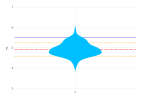

In [110]:
each_lams_mean = mean(each_lams)
each_lams_std = std(each_lams)
upperline = each_lams_mean + each_lams_std
middleline = each_lams_mean
lowerline = each_lams_mean - each_lams_std
trueline = λ
plot(y=each_lams, yintercept = [upperline, middleline, lowerline, trueline],
    Geom.violin, Geom.hline(color=["orange","red","orange","blue"], style=[:dot,:dash,:dot,:solid]))